- with classification
    - classification으로 1,0 구분하는거랑 regression 둘다 만들어두고,
    - classification=1인 경우에 regression 결과값, classification=0인 경우에 0 넣는 방법

# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    N_SPLITS = 5
    TARGET = 'price(원/kg)'
    KEY_FEATURES = ['item','corporation','location']
    TARGET_TRANSFORMATION = 'identity'
    SUBSET_DEPTH = 3

<br></br>

# Data

## Data Load

In [6]:
# item:
#     TG : 감귤
#     BC : 브로콜리
#     RD : 무
#     CR : 당근
#     CB : 양배추

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
trade_df = pd.read_csv('./data/international_trade.csv')

In [8]:
print(train_df.shape)
train_df.head()

(59397, 7)


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [9]:
print(test_df.shape)
test_df.head()

(1092, 5)


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [10]:
print(trade_df.shape)
trade_df.head()

(1274, 7)


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


<br>

## Preprocessing

In [11]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

In [12]:
def preprocessing(data):
    d = data.copy()
    
    d = d.sort_values(CFG.KEY_FEATURES).reset_index(drop=True)
    
    # (1) datetime format
    d['timestamp'] = d['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    
    # (2) delete unuse features
    unuse_features = ['ID','supply(kg)']
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(unuse_features,axis=1,inplace=True)

    return d

In [13]:
def merge_trade_data(data,trade_data):
    d, td = data.copy(), trade_data.copy()
    
    ### trade data preprocessing
    
    # # (1) 흑자여부
    td.drop('무역수지',axis=1,inplace=True)

    # (2) 품목명 수정 및 필요없는 품목 정보 제거
    replace_dict = {
        '감귤': 'TG',
        '꽃양배추와 브로콜리(broccoli)': 'BC',
        '당근': 'CR',
        '순무': 'RD',
        '양배추': 'CB',
    }
    td['품목명'] = td['품목명'].map(replace_dict)
    td.dropna(subset=['품목명'], inplace=True)
    
    ### merge data
    d['기간'] = [str(t)[:7] for t in d['timestamp']]
    merged = pd.merge(d,td.rename(columns={'품목명':'item'}),how='left',on=['기간','item'])
    merged.drop('기간',axis=1,inplace=True)
    
    # 2023년 3월 데이터는 trade 데이터에 없으므로 가장 최근의 값으로 채워줌
    merged.ffill(inplace=True)
    
    return merged

In [14]:
def feature_engineering(data):
    d = data.copy()
    
    # (1) date columns
    d['year']       = d.timestamp.dt.year
    d['month']      = d.timestamp.dt.month
    d['day']        = d.timestamp.dt.day
    d['weekday']    = d.timestamp.dt.weekday
    d['weekend']    = d.timestamp.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = d.timestamp.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # (3) 무역수지, 흑자여부 추가
    d['무역수지'] = d['수출 금액'] - d['수입 금액']
    d['흑자여부'] = np.where(d['무역수지']>0,1,0)
    
    return d

In [15]:
# from copy import deepcopy
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer

# def imputation(train_data,test_data,method):
#     if method in ['mean','median']:
#         base_imputer = SimpleImputer(missing_values=np.nan, strategy=method)
#     elif method=='mice':
#         base_imputer = IterativeImputer(random_state=CFG.SEED)
#     else:
#         raise ValueError(f"Unknown method={method}")
    
#     numerical_cols = train_data.select_dtypes(include=[int,float]).columns.tolist()
#     numerical_cols = list(set(numerical_cols)-set([CFG.TARGET]))
    
#     train_list = []
#     test_list = []
#     for (item,corporation,location),tr in tqdm(train_data.groupby(['item','corporation','location'])):
#         te = test_data[(test_data['item']==item) & (test_data['corporation']==corporation) & (test_data['location']==location)]
#         imputer = deepcopy(base_imputer)
#         tr[numerical_cols] = imputer.fit_transform(tr[numerical_cols])
#         train_list.append(tr)
#         if len(te)>0:
#             te[numerical_cols] = imputer.transform(te[numerical_cols])
#             test_list.append(te)
        
#     new_train = pd.concat(train_list,axis=0)
#     new_test = pd.concat(test_list,axis=0)
    
#     return new_train.sort_index(), new_test.sort_index()

In [16]:
train_df = preprocessing(train_df)
train_df = merge_trade_data(train_df, trade_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
test_df = merge_trade_data(test_df, trade_df)
test_df = feature_engineering(test_df)

In [17]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br>

## Target Transformation

In [18]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION, offset=1)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=np.array(train_df[CFG.TARGET]).reshape(-1,1),
)

In [19]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br>

## Quantile values of Target

In [20]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=CFG.TARGET,
    cat_features=CFG.KEY_FEATURES,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df = calculator.transform(train_df)
test_df  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=3)


Subset: item + corporation + location: 100%|██████████| 7/7 [00:00<00:00, 30.39it/s]


<br>

## Group Scaler

In [21]:
# num_features = list(set(train_df.columns)-set(CFG.KEY_FEATURES+['timestamp',CFG.TARGET]))

In [22]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df,
#     group=CFG.KEY_FEATURES,
#     num_features=num_features,
# )
# train_df = scaler.transform(train_df)
# test_df  = scaler.transform(test_df)

<br>

## Memory Reduce

In [23]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

<br></br>

# EDA

In [24]:
# (1) key별 건수
train_df.groupby(CFG.KEY_FEATURES).size().head()

item  corporation  location
BC    A            J           1523
                   S           1523
      B            J           1523
                   S           1523
      C            J           1523
dtype: int64

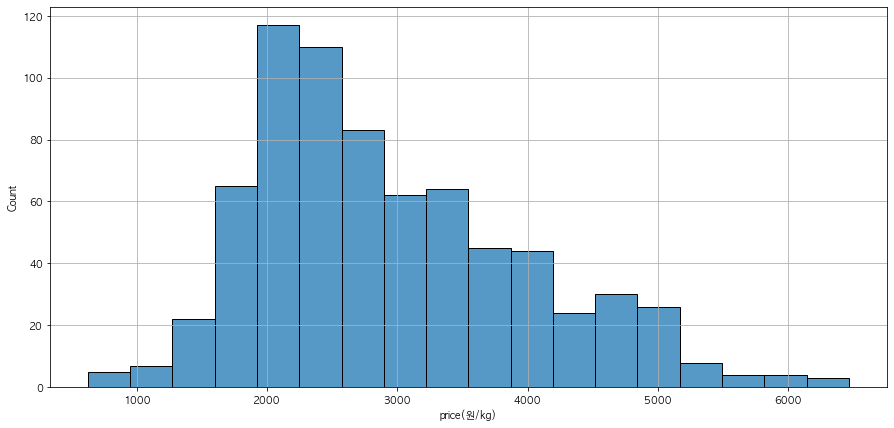

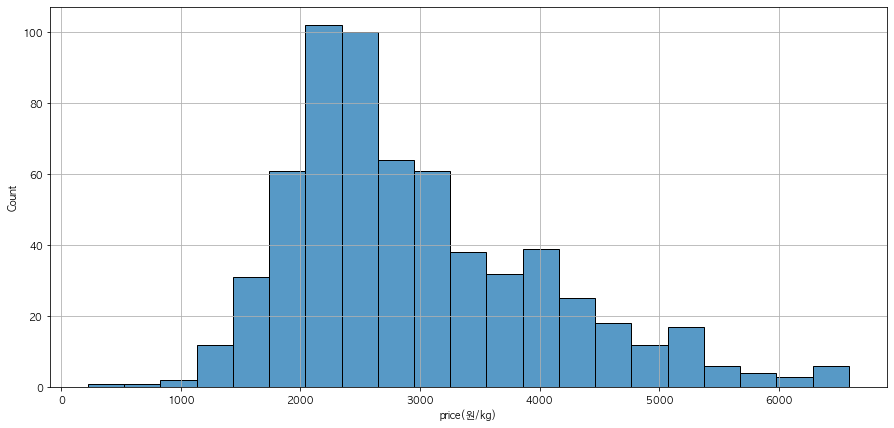

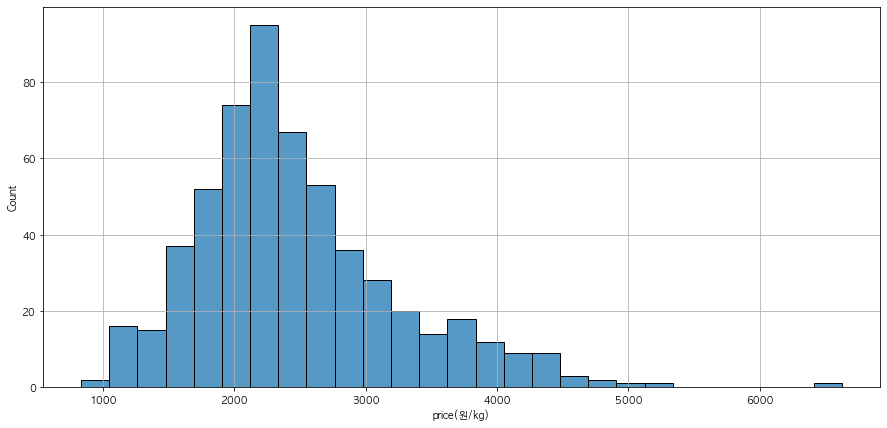

In [25]:
# (2) 품목/법인/지역에 따른 가격 히스토그램
# train_df.groupby(CFG.KEY_FEATURES)[CFG.TARGET].agg(Min=np.min,Max=np.max)
for i,(idx,d) in enumerate(train_df.groupby(CFG.KEY_FEATURES)):
    if i<3:
        target = d[CFG.TARGET]
        target = target[target!=0]
        
        plt.figure(figsize=(15,7))
        sns.histplot(target)
        plt.grid()
        plt.show()

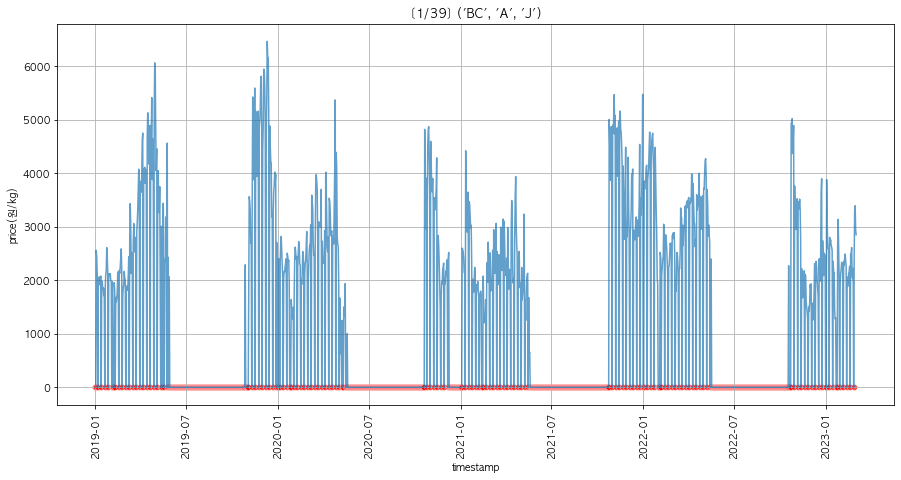

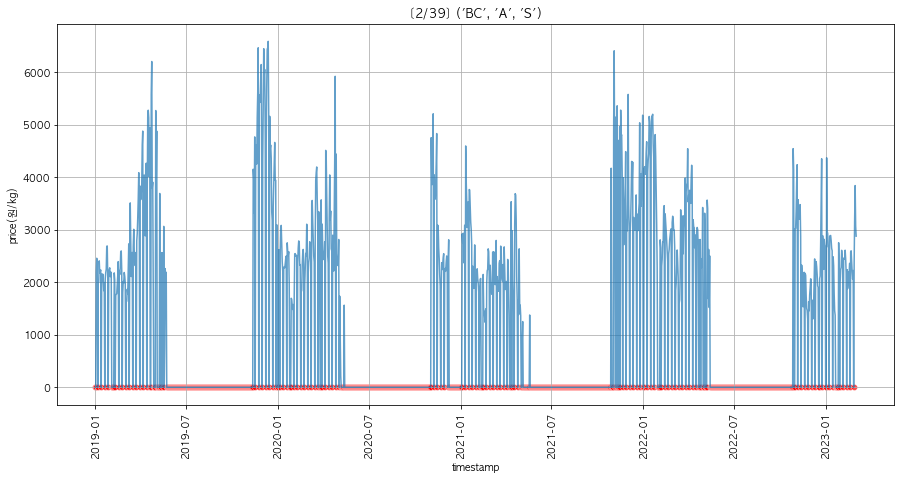

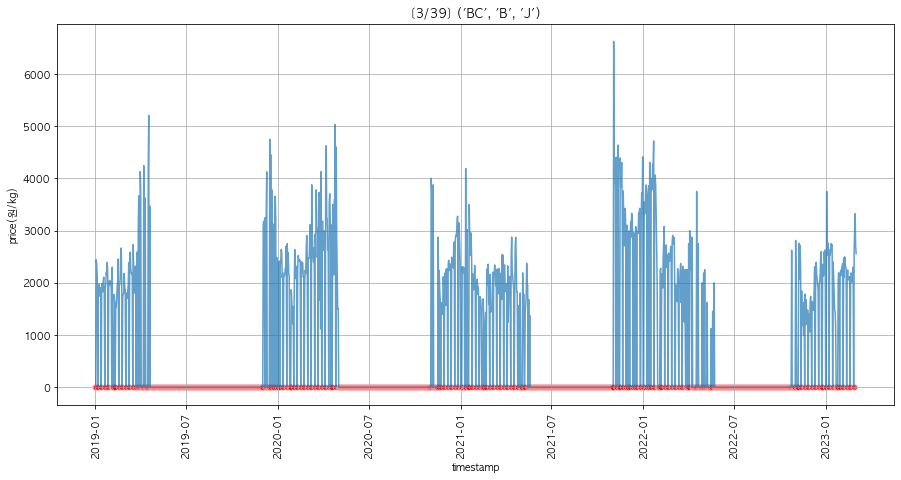

In [26]:
# (3) 품목/법인/지역에 따른 일별 가격변동
grp_data = train_df.groupby(CFG.KEY_FEATURES)
for i,(idx,d) in enumerate(grp_data):
    if i<3:
        plt.figure(figsize=(15,7))
        sns.lineplot(x=d['timestamp'],y=d[CFG.TARGET],alpha=0.7)
        if np.where(d[CFG.TARGET]==0,1,0).sum()>0:
            x=d['timestamp'][d[CFG.TARGET]==0]
            y=d[CFG.TARGET] [d[CFG.TARGET]==0]
            sns.scatterplot(x=x,y=y,color='red',alpha=0.7)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(f'[{i+1}/{len(grp_data)}] {idx}')
        plt.show()

<br></br>

# Modeling

In [27]:
from copy import deepcopy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

def RMSE(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

class WeightedMSELoss:        
    def calc_ders_range(self, approxes, targets, weights):
        alpha = 5
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            residual = targets[index] - approxes[index]
            grad = -2 * alpha * residual if residual > 0 else -2 * residual
            hess = 2 * alpha if residual > 0 else 2.0
            
            if weights is not None:
                grad *= weights[index]
                hess *= weights[index]
            
            result.append((grad, hess))
        return result

In [28]:
# 2) 업데이트버전
#  (1) stacking 추가
#  (2) LGBM에 sample_weight 추가
class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 method='ensemble',
                 use_weightedsum_in_stacking=True):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.method = method
        self.use_weightedsum_in_stacking = use_weightedsum_in_stacking
        
        self._get_regressors()
        
        if use_weightedsum_in_stacking:
            self.stacking_feature = 'pred'
        else:
            self.stacking_feature = [f'pred{i+1}' for i in range(len(self.regressors))]
            
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        cat_loss_function = 'RMSE'
        cat_eval_metric = 'RMSE'
        lgb_metric = 'rmse' # 'rmse','mean_absolute_error'
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
                                 random_state=self.hyperparameters['random_state']),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm1 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm2 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm3 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm4 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm5 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm6 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm7 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm8 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['extratrees_iterations'],
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            # LGBMRegressor(**params_lightgbm1),
            # LGBMRegressor(**params_lightgbm2),
            # LGBMRegressor(**params_lightgbm3),
            # LGBMRegressor(**params_lightgbm4),
            # LGBMRegressor(**params_lightgbm5),
            # LGBMRegressor(**params_lightgbm6),
            # LGBMRegressor(**params_lightgbm7),
            # LGBMRegressor(**params_lightgbm8),
            # ExtraTreesRegressor(**params_extratrees),
        ]
        
        self.stacking_regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost1),
            # CatBoostRegressor(**params_catboost2),
            # CatBoostRegressor(**params_catboost3),
            # CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm1),
            LGBMRegressor(**params_lightgbm2),
            LGBMRegressor(**params_lightgbm3),
            LGBMRegressor(**params_lightgbm4),
            LGBMRegressor(**params_lightgbm5),
            LGBMRegressor(**params_lightgbm6),
            LGBMRegressor(**params_lightgbm7),
            LGBMRegressor(**params_lightgbm8),
            # ExtraTreesRegressor(**params_extratrees),
        ]
        
        self.regressors_name = [type(r).__name__ for r in self.regressors]
        self.stacking_regressors_name = [type(r).__name__ for r in self.stacking_regressors]
        
    def _get_ohe(self,X,cat_features):
        ohe = OneHotEncoder()
        ohe.fit(X,cat_features,remove_first=False)
        return ohe
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _preprocess(self,pred):
        pred = self._set_zero_to_minimum(pred,self.minimum_value)
        pred = self._set_inf_to_maximum(pred,self.maximum_value)
        return pred
    
    def _fit_regressor(self,
                       regressor,regressor_name,
                       X,X_oh,X_val,X_val_oh,y,y_val,cat_features,
                       sample_weight,eval_sample_weight):
        if regressor_name in ['LinearRegression','RidgeCV','LassoCV','ElasticNetCV','ExtraTreesRegressor']:
            warnings.filterwarnings("ignore", category=UserWarning)
            # fitting
            regressor.fit(X_oh,y)
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_oh).flatten())

        elif regressor_name=='XGBRegressor':
            # fitting
            regressor.fit(
                X_oh,y,
                eval_set=[(X_val_oh,y_val)],
                verbose=0,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_oh).flatten())

        elif regressor_name=='CatBoostRegressor':
            # dataset
            train_dataset = Pool(X    ,y    ,cat_features=cat_features)
            val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
            # fitting
            regressor.fit(
                train_dataset,
                eval_set=val_dataset,
                #metric_period=self.hyperparameters['iterations']//50, verbose=True,
                verbose=False,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(train_dataset).flatten())
            va_pred = self._preprocess(regressor.predict(val_dataset)  .flatten())

        elif regressor_name=='LGBMRegressor':
            warnings.filterwarnings("ignore", category=UserWarning)
            # astype category
            X_tmp, X_val_tmp = X.copy(), X_val.copy()
            for col in cat_features:
                X_tmp[col]     = X_tmp[col]    .astype('category')
                X_val_tmp[col] = X_val_tmp[col].astype('category')
            # fitting
            regressor.fit(
                X_tmp,y,
                eval_set=[(X_val_tmp,y_val)],
                sample_weight=sample_weight,
                eval_sample_weight=eval_sample_weight,
                verbose=-1,
            )
            tr_pred = self._preprocess(regressor.predict(X_tmp)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_tmp).flatten())

        else:
            raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
        return regressor, tr_pred, va_pred
            
    def _get_prediction_values(self,X,X_oh,method,regressors_name,regressors,weights,return_weighted):
        if method=='ensemble':
            features    = self.features
            oh_features = self.oh_features
        elif method=='stacking':
            stacking_feature = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            features    = self.features + stacking_feature
            oh_features = self.oh_features + stacking_feature
        
        # (1) 예측값생성
        pred_list = []
        for regressor_name,regressor in zip(regressors_name,regressors):
            if regressor_name in ['LinearRegression','RidgeCV','LassoCV','ElasticNetCV','XGBRegressor','ExtraTreesRegressor']:
                dataset = X_oh[oh_features]
            elif regressor_name=='CatBoostRegressor':
                dataset = Pool(X[features],cat_features=self.cat_features)
            elif regressor_name=='LGBMRegressor':
                dataset = X[features].copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = self._preprocess(regressor.predict(dataset).flatten())
            pred_list.append(y_pred)
        
        # (2) return weighted or original value
        if return_weighted:
            final_pred = np.zeros(len(X))
            for pred,weight in zip(pred_list,weights):
                final_pred += np.array(pred)*weight
            if self.inverse_transform is not None:
                final_pred = self.inverse_transform(np.array(final_pred))
                final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
        else:
            final_pred = np.array(pred_list).T
            
        return final_pred
        
    def _predict(self,X,method='stacking',return_weighted=True):
        if len(self.cat_features)>0:
            X_oh = self.ohe.transform(X)
        else:
            X_oh = X.copy()
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        assert method in ['ensemble','stacking'], \
            "method must be one of ['ensemble','stacking']"
        
        # (1) ensemble
        pred_list = self._get_prediction_values(
            X,X_oh,
            'ensemble',
            self.regressors_name,self.regressors,
            self.ensemble_weights,return_weighted,
        )
        
        if method=='ensemble':
            return pred_list
        
        elif method=='stacking':
            # (2) stacking
            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            pred_df = pd.DataFrame(pred_list,columns=columns,index=X.index)
            
            X    = pd.concat([X   ,pred_df],axis=1)
            X_oh = pd.concat([X_oh,pred_df],axis=1)

            pred_list = self._get_prediction_values(
                X,X_oh,
                'stacking',
                self.stacking_regressors_name,self.stacking_regressors,
                self.stacking_weights,return_weighted,
            )
            return pred_list
        
    def get_feature_importance(self):
        # feature_importances_를 지원하는 모델들
        supported_models = ['CatBoostRegressor','XGBRegressor','LGBMRegressor','ExtraTreesRegressor']
        
        # 지원하지않는 모델이 있는 경우 warning message
        not_supported = [n for n in self.regressors_name if n not in supported_models]
        if len(not_supported)>0:
            warnings.warn("not support model: {}".format(not_supported))

        # get weighted feature importance by using ensemble_weights
        feature_importance_df = pd.DataFrame(self.features,columns=['feature'])
        for i,(regressor,regressor_name,weight) in enumerate(zip(self.regressors,self.regressors_name,self.ensemble_weights)):
            if regressor_name in supported_models:
                feature_importance = regressor.feature_importances_
                fi_list = []
                for feature in self.features:
                    fi = feature_importance[np.where(np.array(self.features)==feature)[0]]
                    fi_list.append([feature,sum(fi)])

                imp_col = f'importance{i}'
                fi_df = pd.DataFrame(fi_list,columns=['feature',imp_col]).sort_values(imp_col,ascending=False)
                fi_df[imp_col] = 100 * fi_df[imp_col] / fi_df[imp_col].sum()
                fi_df[imp_col] *= weight

                feature_importance_df = pd.merge(feature_importance_df,fi_df,how='left',on='feature')

        feature_importance_df = feature_importance_df.fillna(0)
        feature_importance_df['importance'] = feature_importance_df.drop('feature',axis=1).sum(axis=1)
        feature_importance_df = feature_importance_df[['feature','importance']]
        
        return feature_importance_df
        
    def plot_feature_importance(self):
        feature_importance_df = self.get_feature_importance()
        feature_importance_df.sort_values('importance',ascending=True,inplace=True)
        plt.figure(figsize=(15,7))
        plt.barh(feature_importance_df['feature'],feature_importance_df['importance'])
        plt.show()
            
    def fit(self,
            X,y,eval_set,cat_features,
            sample_weight=None,eval_sample_weight=None,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        
        self.sample_weight = sample_weight
        self.eval_sample_weight = eval_sample_weight
        self.cat_features = cat_features
        self.enable_categorical = [True if col in cat_features else False for col in X.columns]
        
        #----------------------------------------------------------------------------------------#
        # prepare dataset
        #----------------------------------------------------------------------------------------#
        X_val, y_val = eval_set[0]
        
        del_cols = return_unique_columns(X)
        X.drop(del_cols,axis=1,inplace=True)
        X_val.drop(del_cols,axis=1,inplace=True)
        self.cat_features = list(set(cat_features)-set(del_cols))
        
        if len(self.cat_features)>0:
            self.ohe = self._get_ohe(X,cat_features)
            X_oh = self.ohe.transform(X)
            X_val_oh = self.ohe.transform(X_val)
        else:
            X_oh = X.copy()
            X_val_oh = X_val.copy()
        
        del_oh_cols = return_unique_columns(X_oh)
        X_oh.drop(del_oh_cols,axis=1,inplace=True)
        X_val_oh.drop(del_oh_cols,axis=1,inplace=True)
        
        #----------------------------------------------------------------------------------------#
        # save feature names
        #----------------------------------------------------------------------------------------#
        self.features    = X   .columns.tolist()
        self.oh_features = X_oh.columns.tolist()
        
        #----------------------------------------------------------------------------------------#
        # true value
        #----------------------------------------------------------------------------------------#
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        #----------------------------------------------------------------------------------------#
        # set min,max value
        #----------------------------------------------------------------------------------------#
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        #----------------------------------------------------------------------------------------#
        # (1) ensemble fitting
        #----------------------------------------------------------------------------------------#
        # prepare ensemble fitting
        self.ensemble_scores = []
        self.ensemble_weights = []
        self.ensemble_fitting_elapsed = []
        ensemble_pbar = zip(self.regressors_name,self.regressors)

        # fitting
        if self.method=='stacking':
            if verbose:
                print('\n########  <Step1> Ensemble  ########')
        for fit_iter,(regressor_name,regressor) in enumerate(ensemble_pbar):
            s = time.time()
                
            # fit
            regressor, tr_pred, va_pred = self._fit_regressor(
                regressor, regressor_name,
                X, X_oh, X_val, X_val_oh, y, y_val, self.cat_features,
                sample_weight, eval_sample_weight,
            )
            self.regressors[fit_iter] = regressor
            
            # progress
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self.inverse_transform(va_pred)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
            va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
            
            e = time.time()
            self.ensemble_scores.append(va_score)
            self.ensemble_weights.append(1/va_score)
            self.ensemble_fitting_elapsed.append(e-s)
            
            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter+1,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)
            
        # get weighted prediction & score
        if self.weight=='equal':
            self.ensemble_weights = np.array([1.0 for _ in self.regressors])
        self.ensemble_weights /= sum(self.ensemble_weights)
        
        tr_pred = self._predict(X,method='ensemble',return_weighted=True)
        va_pred = self._predict(X_val,method='ensemble',return_weighted=True)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.ensemble_fitting_elapsed))
            print(ens_fit_progress)
        
        if self.method=='ensemble':
            self.total_score = ens_va_score
            
        elif self.method=='stacking':
            #----------------------------------------------------------------------------------------#
            # (2) stacking fitting
            #----------------------------------------------------------------------------------------#
            tr_pred = self._predict(X,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)
            va_pred = self._predict(X_val,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)

            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            tr_pred_df = pd.DataFrame(tr_pred,columns=columns,index=X.index)
            va_pred_df = pd.DataFrame(va_pred,columns=columns,index=X_val.index)
            
            X        = pd.concat([X       ,tr_pred_df],axis=1)
            X_oh     = pd.concat([X_oh    ,tr_pred_df],axis=1)
            X_val    = pd.concat([X_val   ,va_pred_df],axis=1)
            X_val_oh = pd.concat([X_val_oh,va_pred_df],axis=1)

            # prepare stacking fitting
            self.stacking_scores = []
            self.stacking_weights = []
            self.stacking_fitting_elapsed = []

            stacking_regressors = deepcopy(self.stacking_regressors)
            stacking_pbar =  zip(self.stacking_regressors_name,stacking_regressors)

            if verbose:
                print('\n########  <Step2> Stacking  ########')
            self.stacking_regressors = []
            for fit_iter,(regressor_name,regressor) in enumerate(stacking_pbar):
                s = time.time()

                # fitting
                stacking_regressor, tr_pred, va_pred = self._fit_regressor(
                    regressor, regressor_name,
                    X, X_oh, X_val, X_val_oh, y, y_val, self.cat_features,
                    sample_weight, eval_sample_weight,
                )
                self.stacking_regressors.append(stacking_regressor)

                # progress
                if self.inverse_transform is not None:
                    tr_pred = self.inverse_transform(tr_pred)
                    tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                    va_pred = self.inverse_transform(va_pred)
                    va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)

                tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
                va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)

                e = time.time()
                self.stacking_scores.append(va_score)
                self.stacking_weights.append(1/va_score)
                self.stacking_fitting_elapsed.append(e-s)

                if verbose:
                    blank = ' '*(11-len(regressor_name))
                    fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                        .format(fit_iter+1,len(stacking_regressors),regressor_name,blank,tr_score,va_score,e-s)
                    print(fit_progress)

            # get weighted prediction & score
            if self.weight=='equal':
                self.stacking_weights = np.array([1.0 for _ in self.stacking_regressors])
            self.stacking_weights /= sum(self.stacking_weights)

            tr_pred = self._predict(
                X   .drop(self.stacking_feature,axis=1),
                X_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )
            va_pred = self._predict(
                X_val   .drop(self.stacking_feature,axis=1),
                X_val_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )

            ## -> self.predict에서 inverse_transform 해줌
            # if self.inverse_transform is not None:
            #     tr_pred = self.inverse_transform(tr_pred)
            #     va_pred = self.inverse_transform(va_pred)

            stacking_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
            stacking_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)

            if verbose:
                stacking_fit_progress = "<Weighted Stacking(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                    .format(self.weight,stacking_tr_score,stacking_va_score,sum(self.stacking_fitting_elapsed))
                print(stacking_fit_progress)

            self.total_score = stacking_va_score
            
        self.feature_importances_ = self.get_feature_importance()['importance'].values.tolist()

    def predict(self,X,method=None):
        if method is None:
            method = self.method
        if (self.method=='ensemble') & (method=='stacking'):
            raise ValueError("The training method is 'ensemble', so 'stacking' prediction is not possible")
        return self._predict(X,method=self.method,return_weighted=self.use_weightedsum_in_stacking)
        
    def save_model(self,path):
        save_dict = {
            'ohe' : self.ohe,
            'cat_features' : self.cat_features,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'sample_weight' : self.sample_weight,
            'eval_sample_weight' : self.eval_sample_weight,
            
            'regressors' : self.regressors,
            'ensemble_weights' : self.ensemble_weights,
            'ensemble_fitting_elapsed' : self.ensemble_fitting_elapsed,
            'ensemble_scores' : self.ensemble_scores,
            
            'total_score' : self.total_score,
        }
        if self.method=='stacking':
            additional_save_dict = {
                'stacking_regressors' : self.stacking_regressors,
                'stacking_weights' : self.stacking_weights,
                'stacking_fitting_elapsed' : self.stacking_fitting_elapsed,
                'stacking_scores' : self.stacking_scores,
            }
            save_dict = {**save_dict,**additional_save_dict}
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.ohe = save_dict['ohe']
            self.cat_features = save_dict['cat_features']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.sample_weight = save_dict['sample_weight']
            self.eval_sample_weight = save_dict['eval_sample_weight']
            
            self.regressors = save_dict['regressors']
            self.ensemble_weights = save_dict['ensemble_weights']
            self.ensemble_fitting_elapsed = save_dict['ensemble_fitting_elapsed']
            self.ensemble_scores = save_dict['ensemble_scores']
            
            self.total_score = save_dict['total_score']
            
            if self.method=='stacking':
                self.stacking_regressors = save_dict['stacking_regressors']
                self.stacking_weights = save_dict['stacking_weights']
                self.stacking_fitting_elapsed = save_dict['stacking_fitting_elapsed']
                self.stacking_scores = save_dict['stacking_scores']

In [29]:
class KfoldWeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 method='ensemble',
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 use_ensemble=True,
                 n_splits=5,
                 random_state=0):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.method = method
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.use_ensemble = use_ensemble
        self.n_splits = n_splits
        self.random_state = random_state
        
    def get_feature_importance(self):
        fs = [m.features for m in self.base_models]
        fs = list(set(item for sublist in fs for item in sublist))
        feature_importance_df = pd.DataFrame(fs,columns=['feature'])

        for i,(base_model,base_feature_importance) in enumerate(zip(self.base_models,self.base_feature_importances)):
            imp_col = f'imp{i}'
            imp_df = pd.DataFrame({
                'feature' : base_model.features,
                imp_col : base_feature_importance,
            })
            feature_importance_df = pd.merge(feature_importance_df,imp_df,how='left',on='feature')

        feature_importance_df.fillna(0,inplace=True)
        feature_importance_df['importance'] = feature_importance_df.drop('feature',axis=1).sum(axis=1)
        feature_importance_df['importance'] = 100 * feature_importance_df['importance'] / feature_importance_df['importance'].sum()
        
        return feature_importance_df
        
    def plot_feature_importance(self):
        feature_importance_df = self.get_feature_importance()
        feature_importance_df.sort_values('importance',ascending=True,inplace=True)

        plt.figure(figsize=(15,7))
        plt.barh(feature_importance_df.feature,feature_importance_df.importance)
        plt.show()
        
    def fit(self,X,y,cat_features,sample_weight=None,verbose=True):
        self.cat_features = cat_features
        self.sample_weight = sample_weight
        self.features = X.columns.tolist()

        self.base_models = []
        self.base_scores = []
        self.base_feature_importances = []
        kf = KFold(n_splits=self.n_splits,random_state=self.random_state,shuffle=True)

        progress_fmt = '> KFold: {}/{}'
        for k, (tr_idx, val_idx) in enumerate(kf.split(X)):
            k_str = str(k+1).zfill(len(str(self.n_splits)))
            print('')
            print('-'*80)
            print(progress_fmt.format(k_str,self.n_splits))
            print('-'*80)
            
            X_tr   , X_va    = X   .iloc[tr_idx], X   .iloc[val_idx]
            y_tr   , y_va    = y   .iloc[tr_idx], y   .iloc[val_idx]
            
            if self.sample_weight is None:
                sample_weight = None
                eval_sample_weight = None
            else:
                sample_weight = self.sample_weight[tr_idx]
                eval_sample_weight = self.sample_weight[val_idx]

            #------------------------------------------------------------------------------------#
            # (1) base model
            #------------------------------------------------------------------------------------#
            # define the base model
            base_model = WeightedEnsembleRegressor(
                hyperparameters=hyperparameters,
                method=self.method, # 'ensemble', 'stacking'
                weight='balanced', # 'equal', 'balanced',
                inverse_transform=self.inverse_transform,
                use_weightedsum_in_stacking=True,
            )
            # fit the model
            base_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                cat_features=cat_features,
                sample_weight=sample_weight,
                eval_sample_weight=[eval_sample_weight],
                verbose=verbose,
            )
            
            # prediction
            y_pred = base_model.predict(X_va).flatten()
            if self.inverse_transform is not None:
                y_true = self.inverse_transform(y_va.values)
            else:
                y_true = y_va.values.flatten()
            
            # caculate score
            score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

            # append inner loop
            self.base_models.append(base_model)
            self.base_scores.append([k+1,len(X_tr),len(X_va),score])
            self.base_feature_importances.append(base_model.feature_importances_)
            
            # # plot feature importance
            # base_model.plot_feature_importance()
        
        self.base_score = pd.DataFrame(self.base_scores,columns=['k','n_train','n_val','rmse'])
        self.validation_score = self.base_score.rmse.mean()
        
        self.plot_feature_importance()
        
    def predict(self,X):
        pred = [base_model.predict(X) for base_model in self.base_models]
        pred = np.mean(pred,axis=0)
        return pred
    
    def save_model(self,path):
        save_dict = {
            'hyperparameters' : self.hyperparameters,
            'weight' : self.weight,
            'n_splits' : self.n_splits,
            'random_state' : self.random_state,
            'inverse_transform' : self.inverse_transform,
            'cat_features' : self.cat_features,
            'sample_weight' : self.sample_weight,
            'base_models' : self.base_models,
            'base_scores' : self.base_scores,
            'base_score' : self.base_score,
            'validation_score' : self.validation_score,
            'base_feature_importances' : self.base_feature_importances,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            
            self.hyperparameters = save_dict['hyperparameters']
            self.weight = save_dict['weight']
            self.n_splits = save_dict['n_splits']
            self.random_state = save_dict['random_state']
            self.inverse_transform = save_dict['inverse_transform']
            self.cat_features = save_dict['cat_features']
            self.sample_weight = save_dict['sample_weight']
            self.base_models = save_dict['base_models']
            self.base_scores = save_dict['base_scores']
            self.base_score = save_dict['base_score']
            self.validation_score = save_dict['validation_score']
            self.base_feature_importances = save_dict['base_feature_importances']

In [30]:
hyperparameters = {
    'n_splits' : CFG.N_SPLITS,
    'max_depth' : 9,
    'random_state' : CFG.SEED,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.3,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     # default=100
}

In [31]:
cat_features = CFG.KEY_FEATURES

In [32]:
mkdir('./mc')

In [33]:
def get_seg_data(data,item,corporation,location):
    d = data.copy()
    return d[(d['item']==item) & (d['corporation']==corporation) & (d['location']==location)]

[01/39] item:BC, corporation:A, location:J:   0%|          | 0/39 [00:00<?, ?it/s]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=8.585, val_loss=389.132, elasped=38.7s
[2/4] CatBoostRegressor: loss=7.430, val_loss=405.379, elasped=55.0s
[3/4] CatBoostRegressor: loss=103.571, val_loss=412.479, elasped=5.0s
[4/4] CatBoostRegressor: loss=0.003, val_loss=385.319, elasped=115.0s
<Weighted Ensemble(weight='balanced')> loss=28.184, val_loss=390.566, elasped=213.7s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=237.090, val_loss=443.585, elasped=4.9s
[2/4] CatBoostRegressor: loss=254.887, val_loss=455.498, elasped=4.3s
[3/4] CatBoostRegressor: loss=291.496, val_loss=449.073, elasped=1.5s
[4/4] CatBoostRegressor: loss=131.798, val_loss=476.401, elasped=10.4s
<Wei

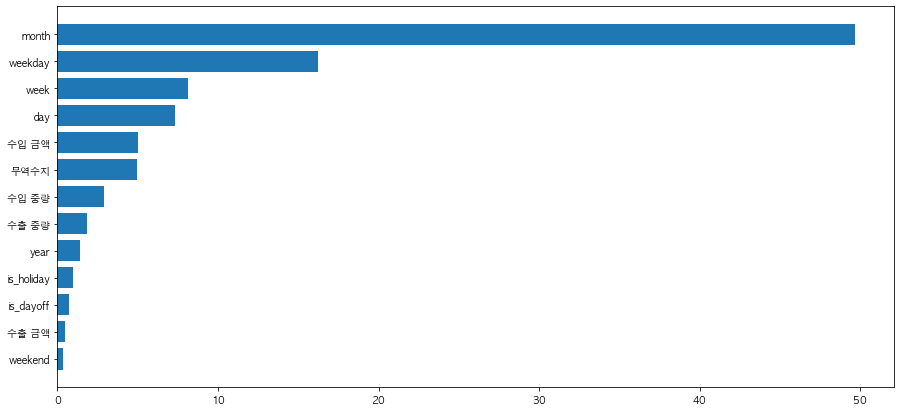

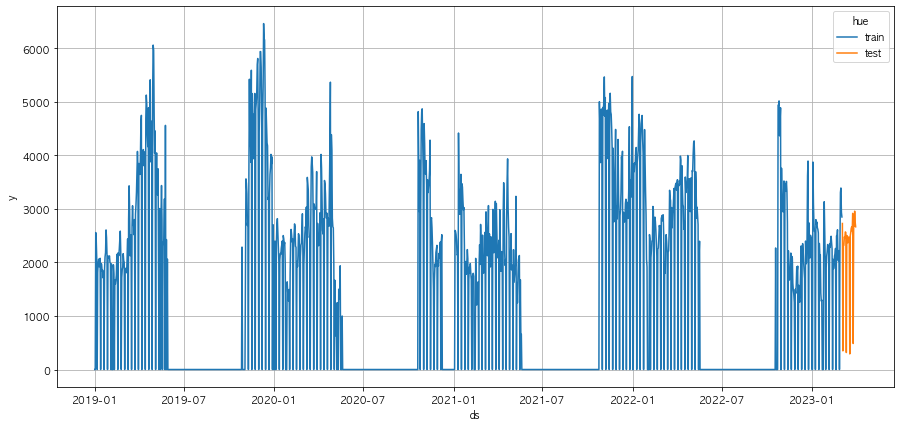

[02/39] item:BC, corporation:A, location:S:   3%|▎         | 1/39 [05:18<3:21:38, 318.39s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=444.080, val_loss=624.397, elasped=2.5s
[2/4] CatBoostRegressor: loss=487.548, val_loss=631.913, elasped=2.1s
[3/4] CatBoostRegressor: loss=519.809, val_loss=657.553, elasped=0.7s
[4/4] CatBoostRegressor: loss=335.518, val_loss=626.673, elasped=5.5s
<Weighted Ensemble(weight='balanced')> loss=442.699, val_loss=630.705, elasped=10.8s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=381.344, val_loss=697.844, elasped=3.1s
[2/4] CatBoostRegressor: loss=384.196, val_loss=700.709, elasped=2.9s
[3/4] CatBoostRegressor: loss=390.173, val_loss=703.306, elasped=1.1s
[4/4] CatBoostRegressor: loss=366.930, val_loss=720.829, elasped=4.9s
<We

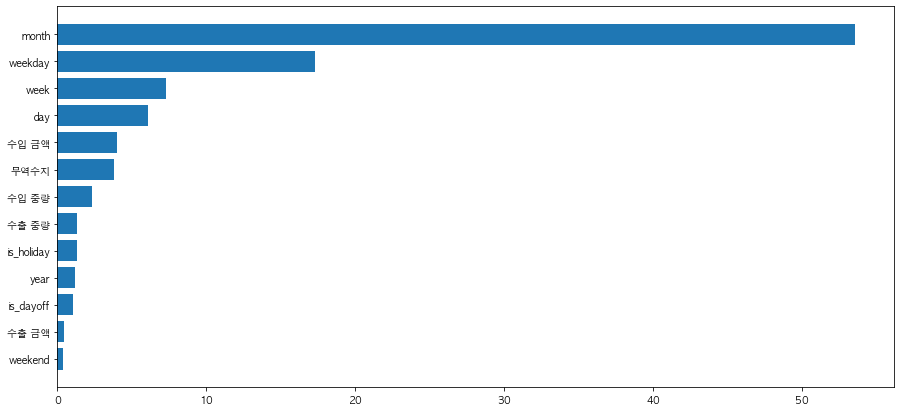

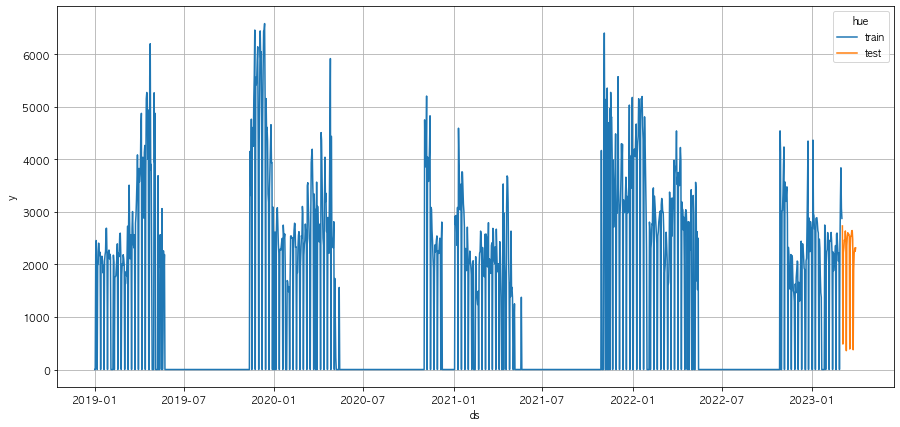

[03/39] item:BC, corporation:B, location:J:   5%|▌         | 2/39 [06:43<1:51:38, 181.04s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=368.658, val_loss=685.831, elasped=3.2s
[2/4] CatBoostRegressor: loss=451.944, val_loss=693.480, elasped=2.2s
[3/4] CatBoostRegressor: loss=441.116, val_loss=694.837, elasped=0.9s
[4/4] CatBoostRegressor: loss=397.625, val_loss=697.750, elasped=4.4s
<Weighted Ensemble(weight='balanced')> loss=411.914, val_loss=689.859, elasped=10.6s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=551.354, val_loss=692.337, elasped=1.7s
[2/4] CatBoostRegressor: loss=569.780, val_loss=694.643, elasped=1.3s
[3/4] CatBoostRegressor: loss=577.039, val_loss=697.689, elasped=0.5s
[4/4] CatBoostRegressor: loss=478.556, val_loss=703.517, elasped=3.3s
<We

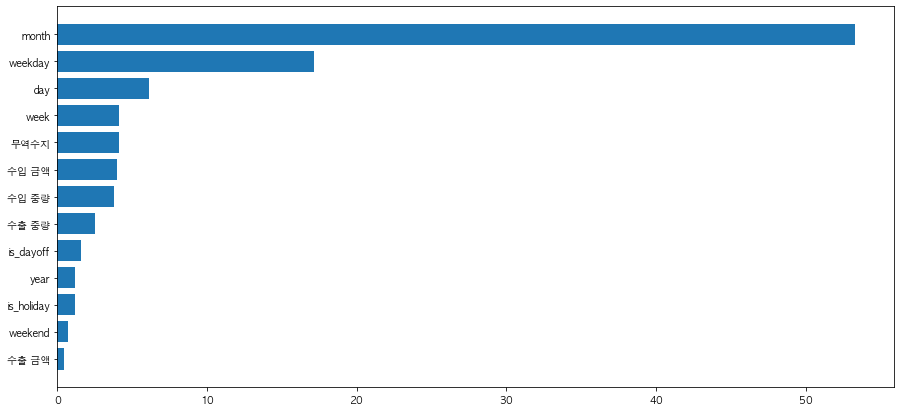

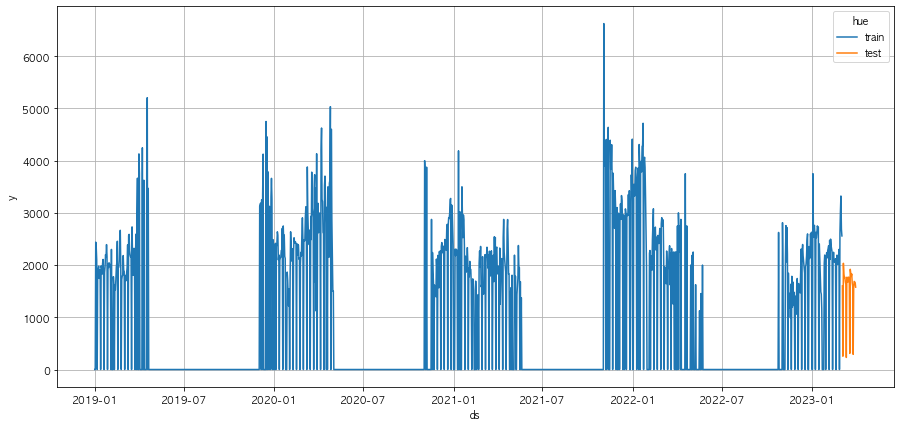

[04/39] item:BC, corporation:B, location:S:   8%|▊         | 3/39 [07:34<1:13:05, 121.83s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=254.938, val_loss=456.906, elasped=1.1s
[2/4] CatBoostRegressor: loss=237.348, val_loss=455.272, elasped=1.3s
[3/4] CatBoostRegressor: loss=227.672, val_loss=453.810, elasped=0.6s
[4/4] CatBoostRegressor: loss=229.016, val_loss=460.313, elasped=2.5s
<Weighted Ensemble(weight='balanced')> loss=234.234, val_loss=454.461, elasped=5.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=370.247, val_loss=371.987, elasped=0.7s
[2/4] CatBoostRegressor: loss=379.832, val_loss=370.869, elasped=0.6s
[3/4] CatBoostRegressor: loss=357.414, val_loss=361.916, elasped=0.2s
[4/4] CatBoostRegressor: loss=373.463, val_loss=383.185, elasped=2.1s
<Wei

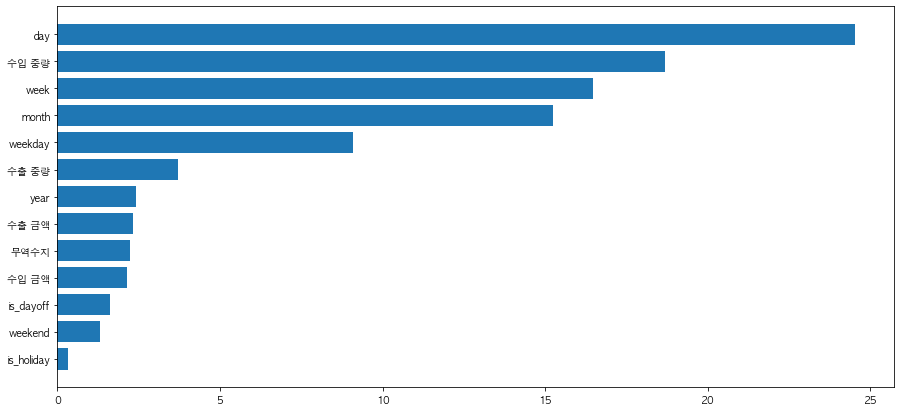

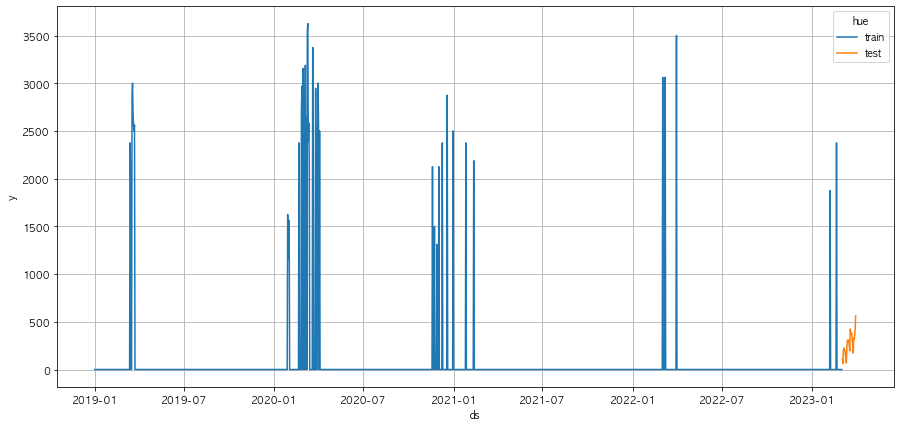

[05/39] item:BC, corporation:C, location:J:  10%|█         | 4/39 [08:06<50:27, 86.49s/it]   


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=492.385, val_loss=679.437, elasped=2.6s
[2/4] CatBoostRegressor: loss=553.772, val_loss=674.715, elasped=1.8s
[3/4] CatBoostRegressor: loss=504.046, val_loss=675.832, elasped=0.9s
[4/4] CatBoostRegressor: loss=489.502, val_loss=684.926, elasped=3.7s
<Weighted Ensemble(weight='balanced')> loss=507.354, val_loss=675.939, elasped=8.9s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=583.672, val_loss=684.414, elasped=1.7s
[2/4] CatBoostRegressor: loss=587.108, val_loss=682.070, elasped=1.4s
[3/4] CatBoostRegressor: loss=569.143, val_loss=684.837, elasped=0.6s
[4/4] CatBoostRegressor: loss=485.670, val_loss=697.073, elasped=3.6s
<Wei

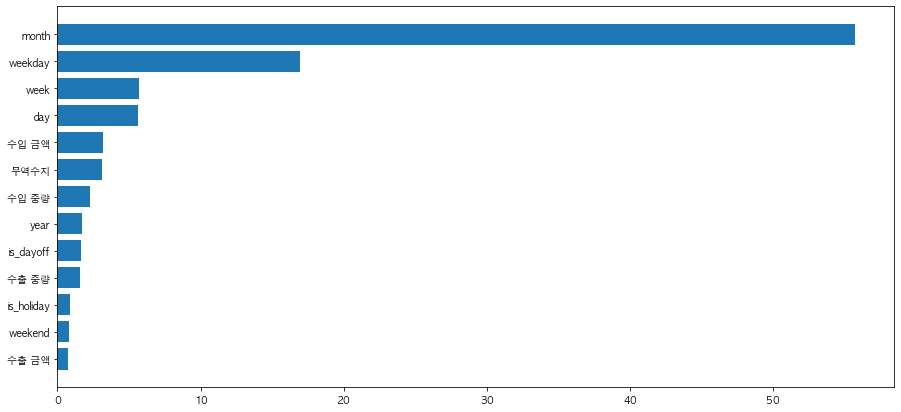

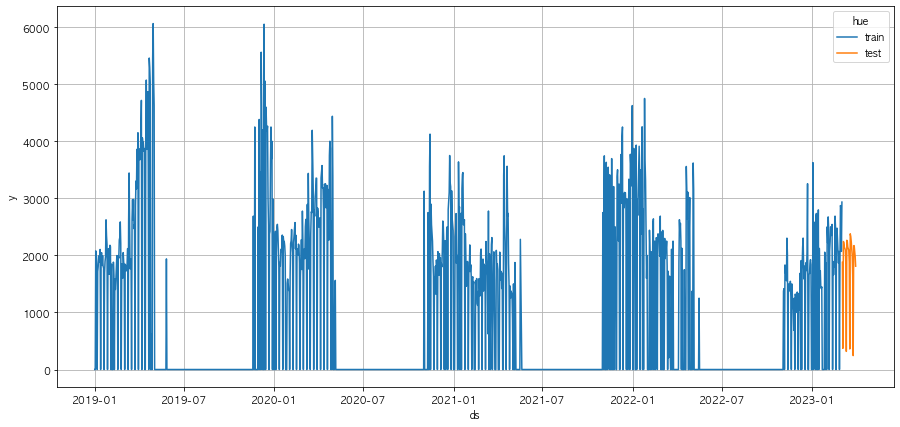

[06/39] item:BC, corporation:C, location:S:  13%|█▎        | 5/39 [08:59<42:06, 74.32s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=46.685, val_loss=332.305, elasped=2.8s
[2/4] CatBoostRegressor: loss=85.745, val_loss=336.195, elasped=2.3s
[3/4] CatBoostRegressor: loss=109.094, val_loss=328.083, elasped=0.7s
[4/4] CatBoostRegressor: loss=8.398, val_loss=333.019, elasped=7.3s
<Weighted Ensemble(weight='balanced')> loss=61.372, val_loss=331.359, elasped=13.1s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=117.546, val_loss=309.924, elasped=1.6s
[2/4] CatBoostRegressor: loss=135.940, val_loss=303.072, elasped=1.3s
[3/4] CatBoostRegressor: loss=108.953, val_loss=297.261, elasped=0.6s
[4/4] CatBoostRegressor: loss=62.743, val_loss=284.881, elasped=3.7s
<Weighted

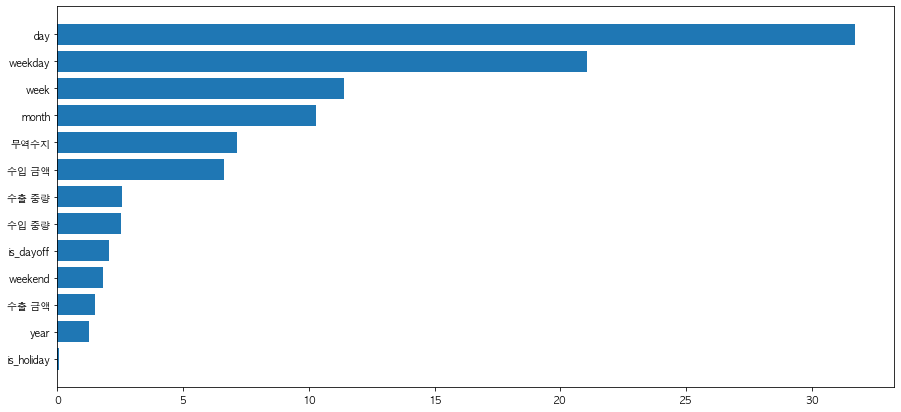

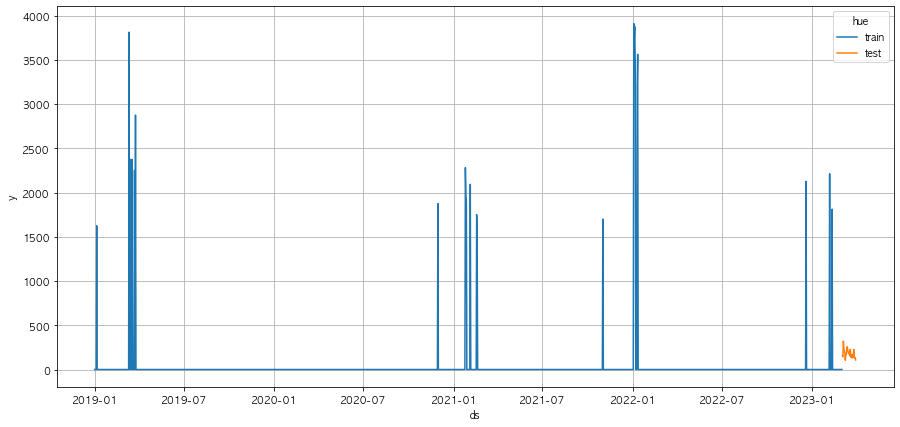

[07/39] item:BC, corporation:D, location:J:  15%|█▌        | 6/39 [09:32<33:04, 60.15s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=435.410, val_loss=566.068, elasped=2.1s
[2/4] CatBoostRegressor: loss=461.123, val_loss=566.900, elasped=1.8s
[3/4] CatBoostRegressor: loss=399.686, val_loss=565.905, elasped=0.8s
[4/4] CatBoostRegressor: loss=333.692, val_loss=566.432, elasped=4.7s
<Weighted Ensemble(weight='balanced')> loss=404.809, val_loss=563.498, elasped=9.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=365.369, val_loss=749.580, elasped=2.6s
[2/4] CatBoostRegressor: loss=248.677, val_loss=728.685, elasped=4.3s
[3/4] CatBoostRegressor: loss=322.021, val_loss=740.471, elasped=1.1s
[4/4] CatBoostRegressor: loss=172.665, val_loss=738.698, elasped=7.4s
<Wei

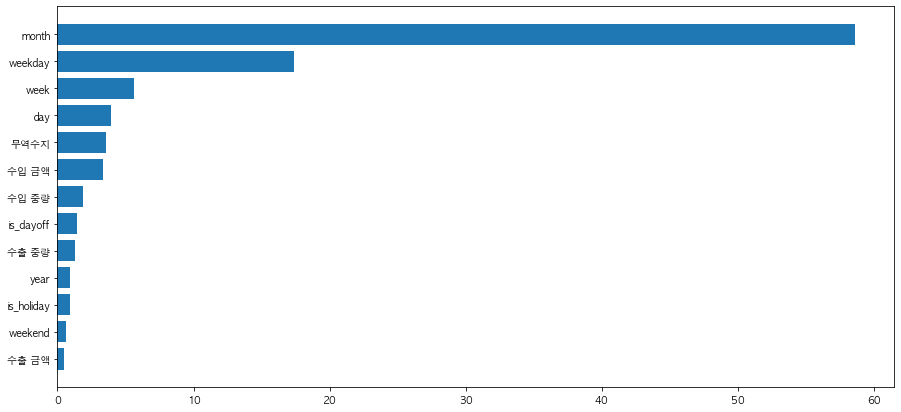

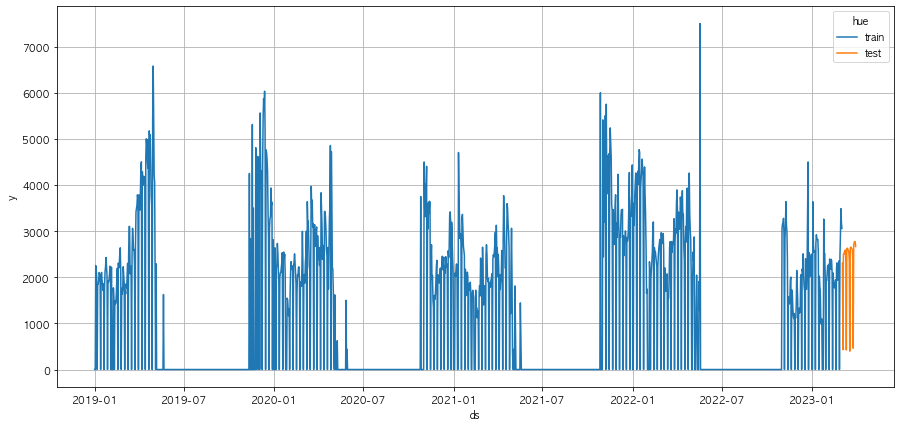

[08/39] item:BC, corporation:E, location:J:  18%|█▊        | 7/39 [10:32<32:03, 60.10s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=181.658, val_loss=661.768, elasped=5.8s
[2/4] CatBoostRegressor: loss=114.916, val_loss=659.383, elasped=10.0s
[3/4] CatBoostRegressor: loss=158.424, val_loss=623.549, elasped=2.9s
[4/4] CatBoostRegressor: loss=0.000, val_loss=636.569, elasped=158.2s
<Weighted Ensemble(weight='balanced')> loss=111.189, val_loss=639.373, elasped=177.0s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=302.118, val_loss=563.930, elasped=3.7s
[2/4] CatBoostRegressor: loss=229.733, val_loss=555.090, elasped=4.8s
[3/4] CatBoostRegressor: loss=258.829, val_loss=581.321, elasped=1.7s
[4/4] CatBoostRegressor: loss=99.124, val_loss=571.278, elasped=12.2s
<

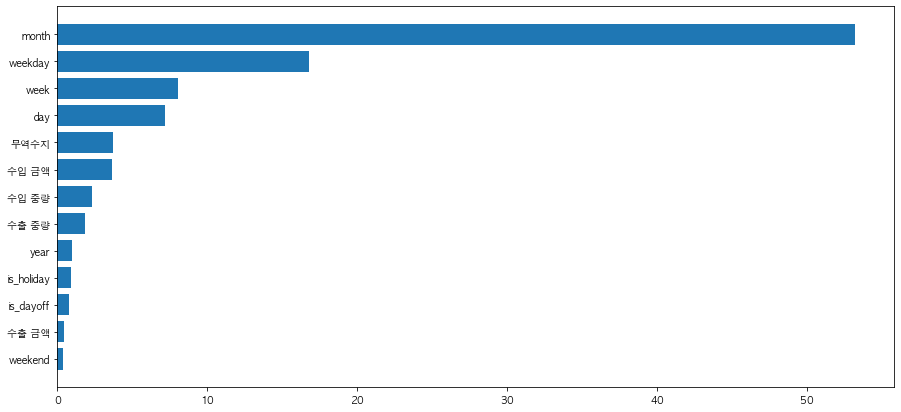

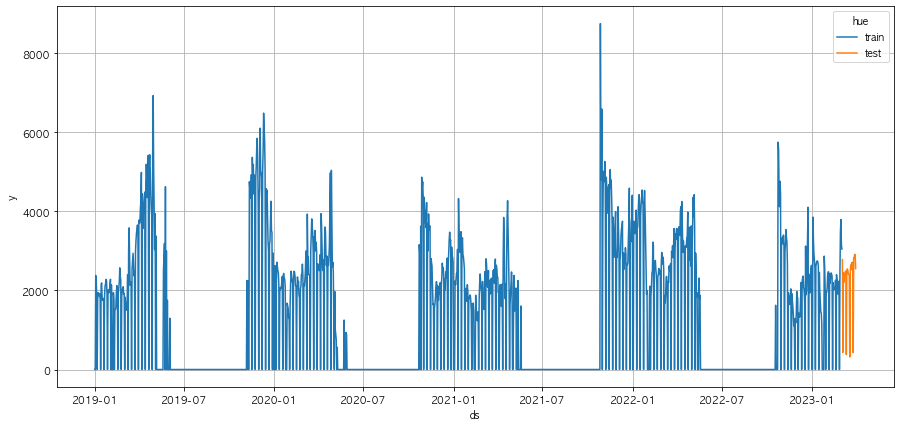

[09/39] item:BC, corporation:E, location:S:  21%|██        | 8/39 [15:17<1:08:05, 131.78s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=430.041, val_loss=872.219, elasped=3.1s
[2/4] CatBoostRegressor: loss=507.741, val_loss=870.866, elasped=2.2s
[3/4] CatBoostRegressor: loss=562.839, val_loss=874.186, elasped=0.7s
[4/4] CatBoostRegressor: loss=358.974, val_loss=873.935, elasped=5.6s
<Weighted Ensemble(weight='balanced')> loss=461.701, val_loss=868.838, elasped=11.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=579.646, val_loss=727.277, elasped=2.0s
[2/4] CatBoostRegressor: loss=628.342, val_loss=722.299, elasped=1.6s
[3/4] CatBoostRegressor: loss=623.792, val_loss=734.283, elasped=0.6s
[4/4] CatBoostRegressor: loss=510.231, val_loss=757.333, elasped=3.7s
<We

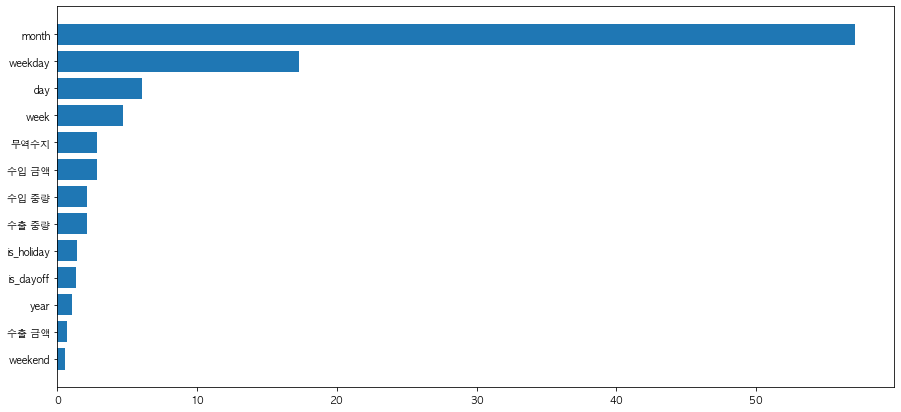

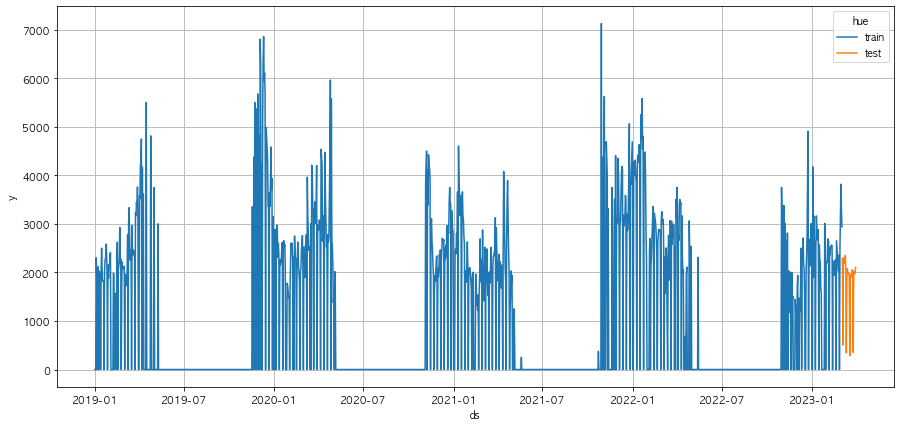

[10/39] item:CB, corporation:A, location:J:  23%|██▎       | 9/39 [16:13<54:04, 108.15s/it]  


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=208.877, val_loss=277.949, elasped=1.8s
[2/4] CatBoostRegressor: loss=214.980, val_loss=278.481, elasped=1.5s
[3/4] CatBoostRegressor: loss=221.243, val_loss=278.510, elasped=0.5s
[4/4] CatBoostRegressor: loss=164.829, val_loss=280.142, elasped=4.2s
<Weighted Ensemble(weight='balanced')> loss=201.672, val_loss=277.809, elasped=8.1s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=236.436, val_loss=268.607, elasped=1.3s
[2/4] CatBoostRegressor: loss=236.889, val_loss=267.089, elasped=1.1s
[3/4] CatBoostRegressor: loss=239.458, val_loss=264.375, elasped=0.4s
[4/4] CatBoostRegressor: loss=202.286, val_loss=274.778, elasped=3.1s
<Wei

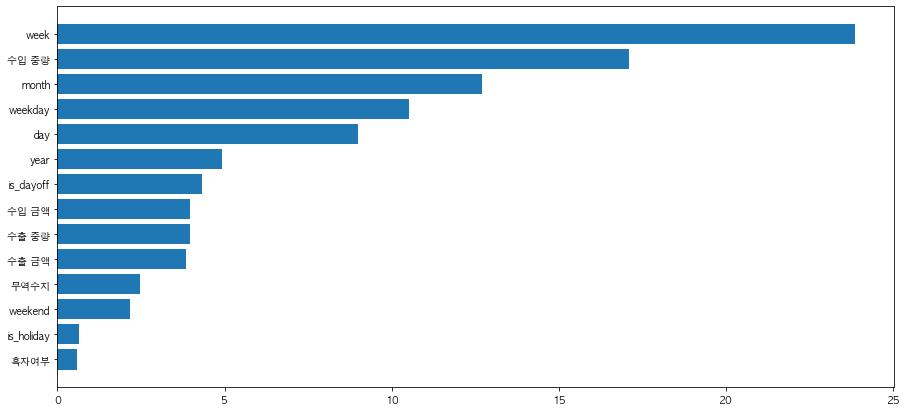

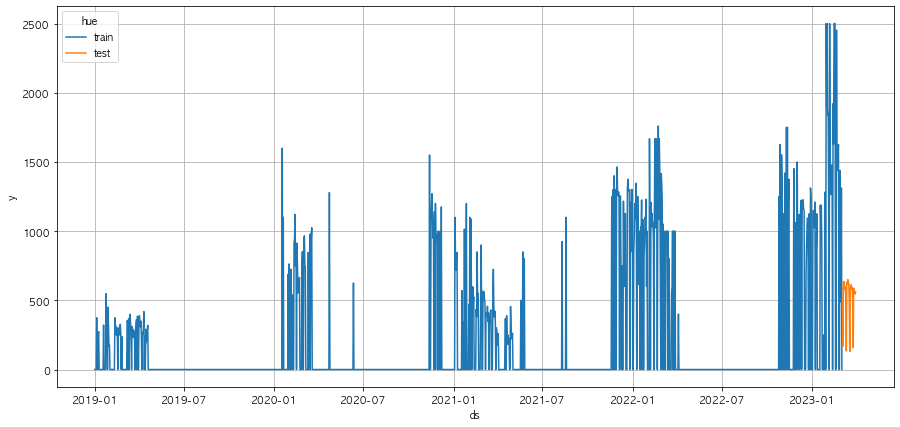

[11/39] item:CB, corporation:A, location:S:  26%|██▌       | 10/39 [17:01<43:18, 89.59s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=38.780, val_loss=52.543, elasped=1.1s
[2/4] CatBoostRegressor: loss=38.365, val_loss=52.541, elasped=1.1s
[3/4] CatBoostRegressor: loss=37.873, val_loss=53.095, elasped=0.4s
[4/4] CatBoostRegressor: loss=31.689, val_loss=54.986, elasped=2.3s
<Weighted Ensemble(weight='balanced')> loss=36.341, val_loss=53.009, elasped=4.9s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=12.926, val_loss=29.979, elasped=3.3s
[2/4] CatBoostRegressor: loss=25.196, val_loss=29.623, elasped=2.7s
[3/4] CatBoostRegressor: loss=30.441, val_loss=32.962, elasped=0.7s
[4/4] CatBoostRegressor: loss=7.837, val_loss=31.717, elasped=5.4s
<Weighted Ensemble(weig

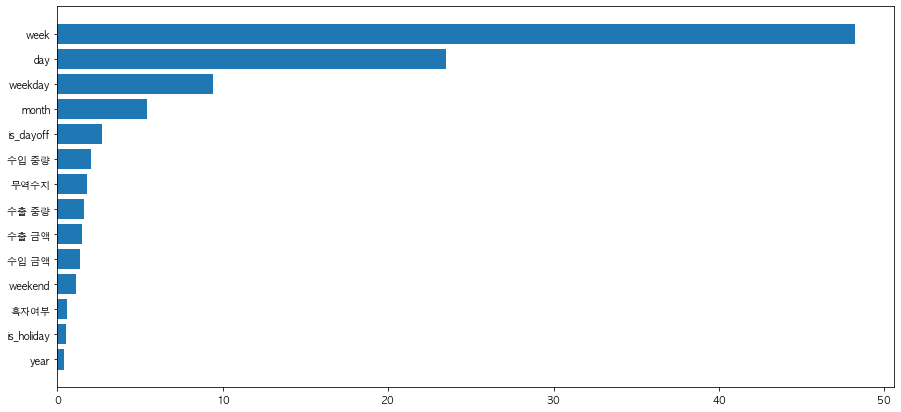

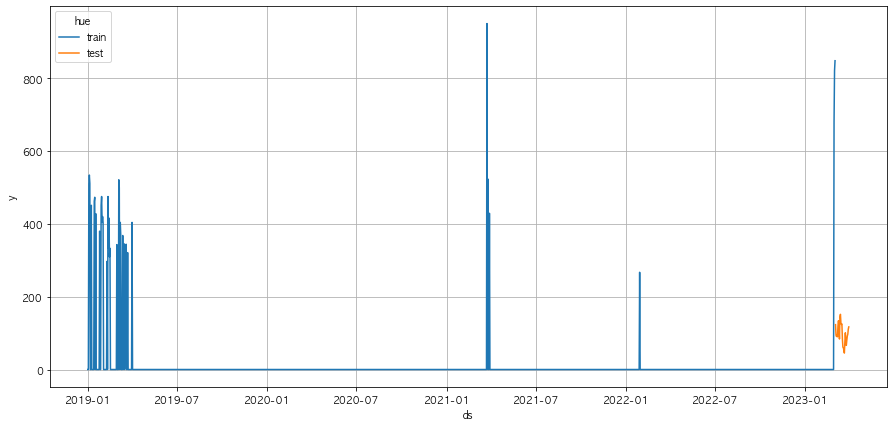

[12/39] item:CB, corporation:D, location:J:  28%|██▊       | 11/39 [17:40<34:31, 73.97s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=116.282, val_loss=160.381, elasped=2.3s
[2/4] CatBoostRegressor: loss=111.915, val_loss=160.689, elasped=2.8s
[3/4] CatBoostRegressor: loss=134.017, val_loss=163.291, elasped=0.6s
[4/4] CatBoostRegressor: loss=102.698, val_loss=161.716, elasped=4.0s
<Weighted Ensemble(weight='balanced')> loss=115.444, val_loss=160.505, elasped=9.7s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=117.107, val_loss=152.170, elasped=2.4s
[2/4] CatBoostRegressor: loss=122.603, val_loss=151.914, elasped=2.0s
[3/4] CatBoostRegressor: loss=123.128, val_loss=151.951, elasped=0.7s
[4/4] CatBoostRegressor: loss=93.775, val_loss=155.035, elasped=4.6s
<Weig

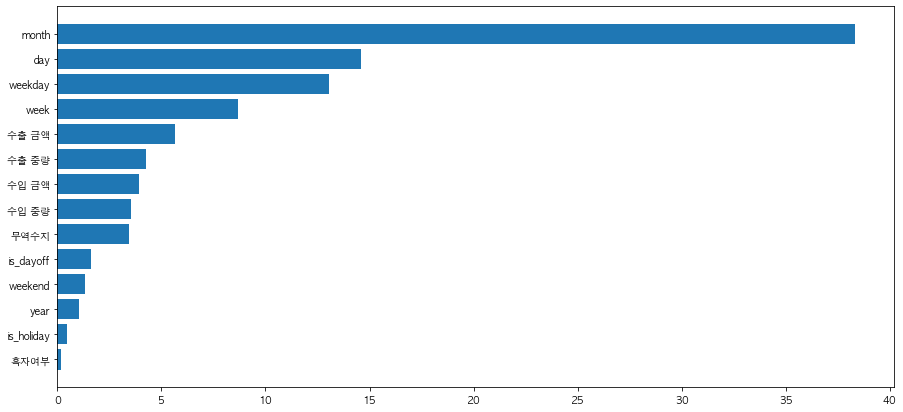

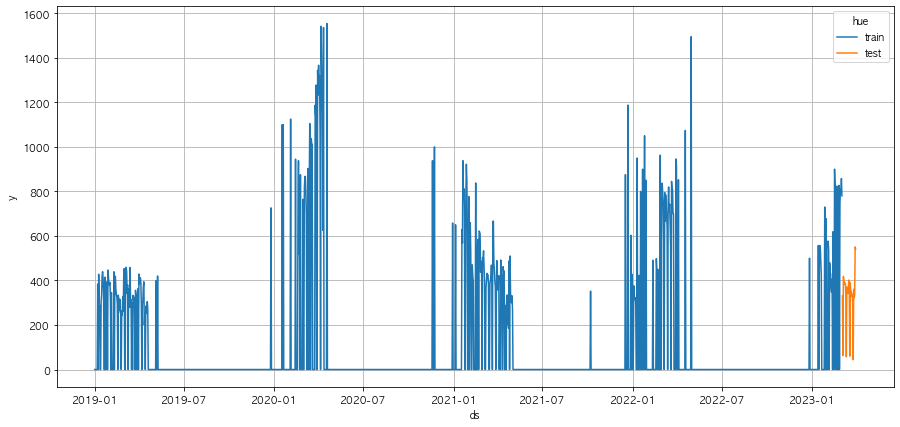

[13/39] item:CB, corporation:E, location:J:  31%|███       | 12/39 [18:25<29:20, 65.21s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=185.619, val_loss=229.192, elasped=1.2s
[2/4] CatBoostRegressor: loss=189.761, val_loss=228.975, elasped=0.9s
[3/4] CatBoostRegressor: loss=192.876, val_loss=231.101, elasped=0.4s
[4/4] CatBoostRegressor: loss=164.316, val_loss=231.061, elasped=3.4s
<Weighted Ensemble(weight='balanced')> loss=182.117, val_loss=228.954, elasped=5.9s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=154.570, val_loss=186.492, elasped=2.3s
[2/4] CatBoostRegressor: loss=173.560, val_loss=186.100, elasped=1.7s
[3/4] CatBoostRegressor: loss=180.492, val_loss=186.093, elasped=0.6s
[4/4] CatBoostRegressor: loss=146.710, val_loss=186.841, elasped=3.9s
<Wei

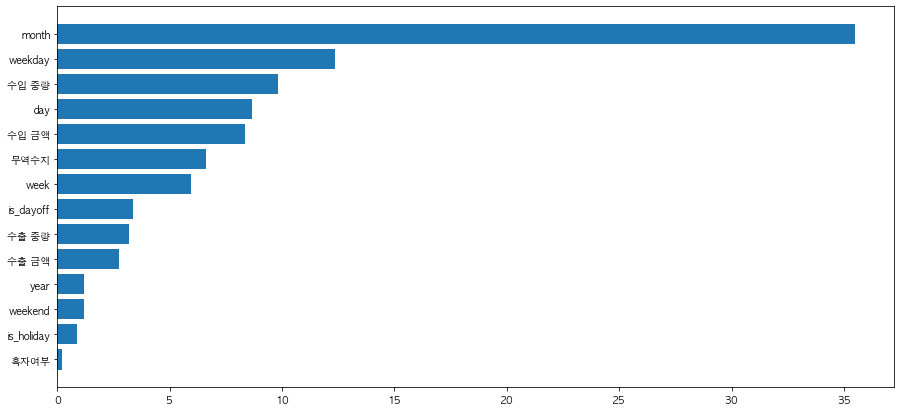

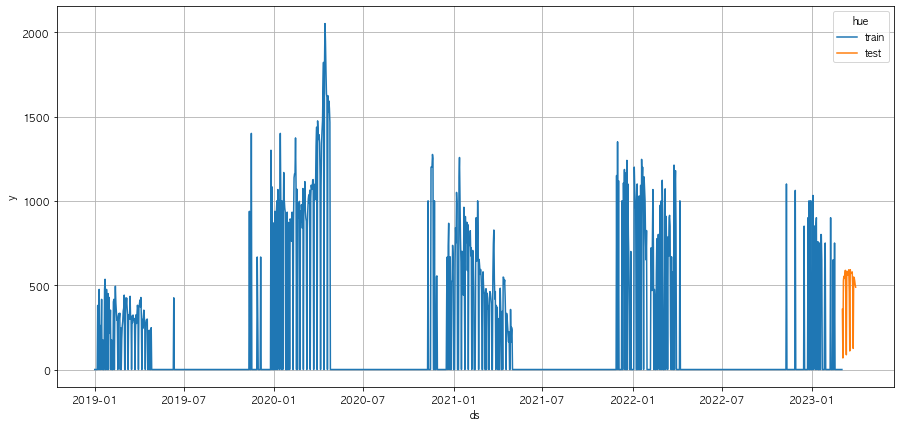

[14/39] item:CB, corporation:F, location:J:  33%|███▎      | 13/39 [19:07<25:13, 58.22s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=41.375, val_loss=152.089, elasped=6.5s
[2/4] CatBoostRegressor: loss=32.273, val_loss=147.007, elasped=9.3s
[3/4] CatBoostRegressor: loss=69.782, val_loss=153.347, elasped=1.4s
[4/4] CatBoostRegressor: loss=0.089, val_loss=147.907, elasped=53.4s
<Weighted Ensemble(weight='balanced')> loss=34.813, val_loss=148.541, elasped=70.6s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=67.219, val_loss=112.489, elasped=3.8s
[2/4] CatBoostRegressor: loss=63.973, val_loss=113.601, elasped=4.1s
[3/4] CatBoostRegressor: loss=58.941, val_loss=117.604, elasped=1.7s
[4/4] CatBoostRegressor: loss=26.218, val_loss=115.223, elasped=11.6s
<Weighted E

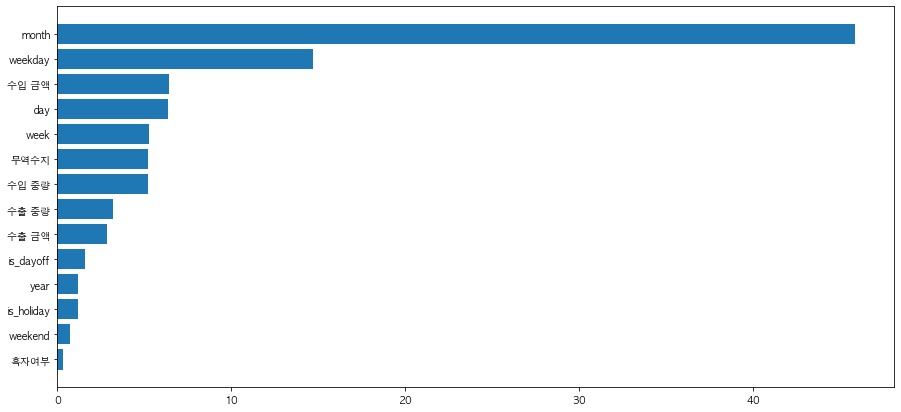

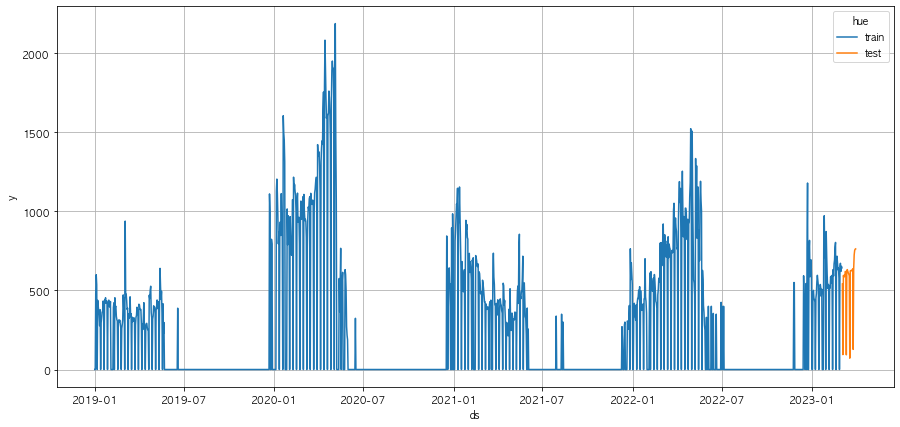

[15/39] item:CR, corporation:A, location:J:  36%|███▌      | 14/39 [22:02<38:56, 93.47s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=311.249, val_loss=394.883, elasped=1.5s
[2/4] CatBoostRegressor: loss=305.428, val_loss=393.869, elasped=1.4s
[3/4] CatBoostRegressor: loss=306.732, val_loss=387.708, elasped=0.5s
[4/4] CatBoostRegressor: loss=254.317, val_loss=408.140, elasped=4.2s
<Weighted Ensemble(weight='balanced')> loss=292.994, val_loss=393.989, elasped=7.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=289.157, val_loss=378.709, elasped=1.8s
[2/4] CatBoostRegressor: loss=294.086, val_loss=376.826, elasped=1.6s
[3/4] CatBoostRegressor: loss=309.449, val_loss=379.318, elasped=0.5s
[4/4] CatBoostRegressor: loss=252.125, val_loss=381.914, elasped=4.0s
<Wei

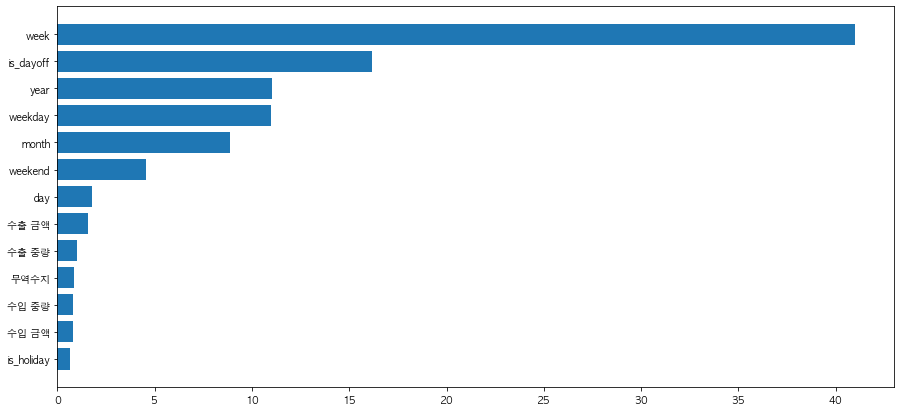

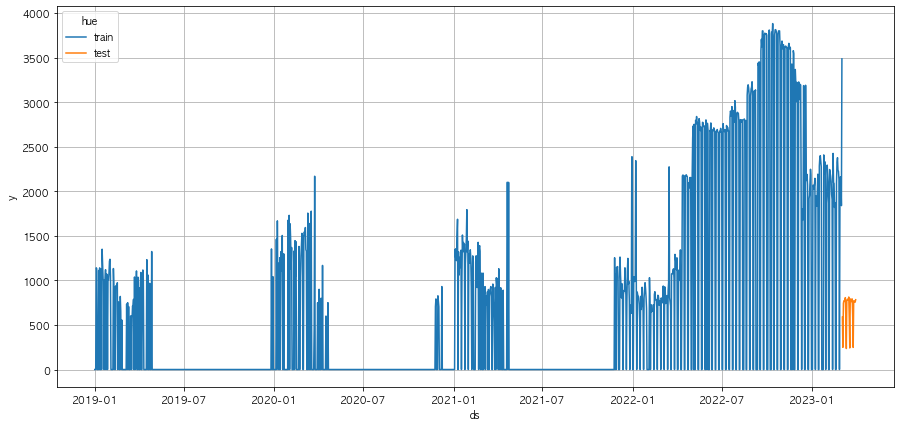

[16/39] item:CR, corporation:B, location:J:  38%|███▊      | 15/39 [22:45<31:16, 78.18s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=195.746, val_loss=351.277, elasped=3.5s
[2/4] CatBoostRegressor: loss=212.875, val_loss=352.780, elasped=3.1s
[3/4] CatBoostRegressor: loss=231.162, val_loss=352.468, elasped=0.8s
[4/4] CatBoostRegressor: loss=212.224, val_loss=366.835, elasped=4.1s
<Weighted Ensemble(weight='balanced')> loss=210.684, val_loss=353.429, elasped=11.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=326.482, val_loss=375.546, elasped=1.1s
[2/4] CatBoostRegressor: loss=338.344, val_loss=374.936, elasped=1.0s
[3/4] CatBoostRegressor: loss=354.999, val_loss=384.096, elasped=0.3s
[4/4] CatBoostRegressor: loss=299.587, val_loss=381.147, elasped=3.1s
<We

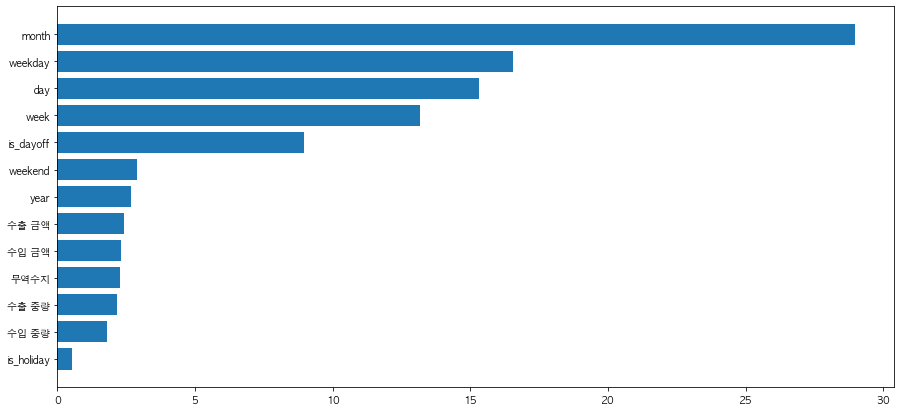

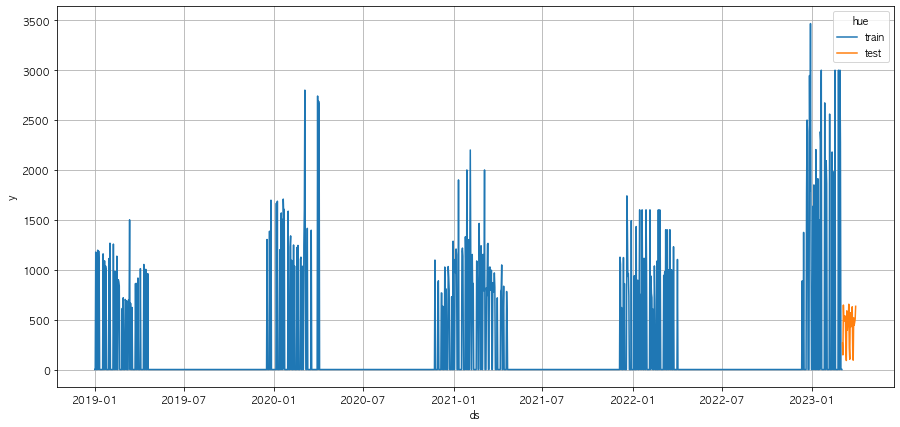

[17/39] item:CR, corporation:C, location:J:  41%|████      | 16/39 [23:27<25:47, 67.30s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=302.118, val_loss=393.459, elasped=2.8s
[2/4] CatBoostRegressor: loss=337.986, val_loss=394.978, elasped=1.8s
[3/4] CatBoostRegressor: loss=335.764, val_loss=393.502, elasped=0.7s
[4/4] CatBoostRegressor: loss=247.340, val_loss=397.067, elasped=5.1s
<Weighted Ensemble(weight='balanced')> loss=304.626, val_loss=393.128, elasped=10.4s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=345.077, val_loss=403.505, elasped=1.5s
[2/4] CatBoostRegressor: loss=355.442, val_loss=398.346, elasped=1.3s
[3/4] CatBoostRegressor: loss=354.276, val_loss=400.538, elasped=0.5s
[4/4] CatBoostRegressor: loss=283.746, val_loss=408.921, elasped=6.6s
<We

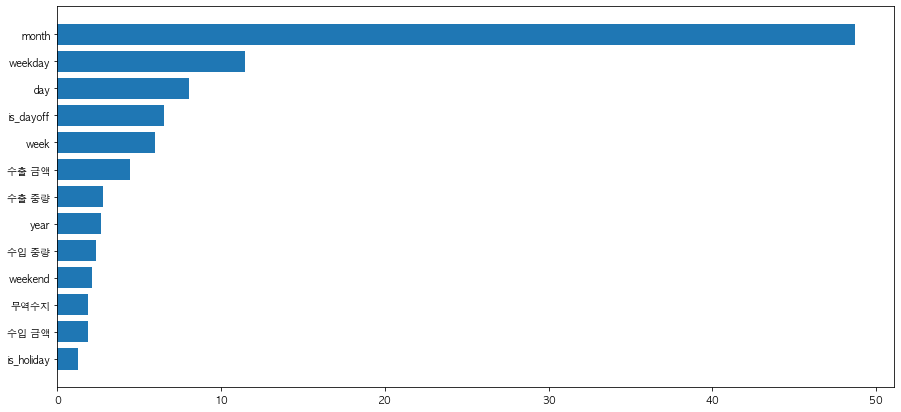

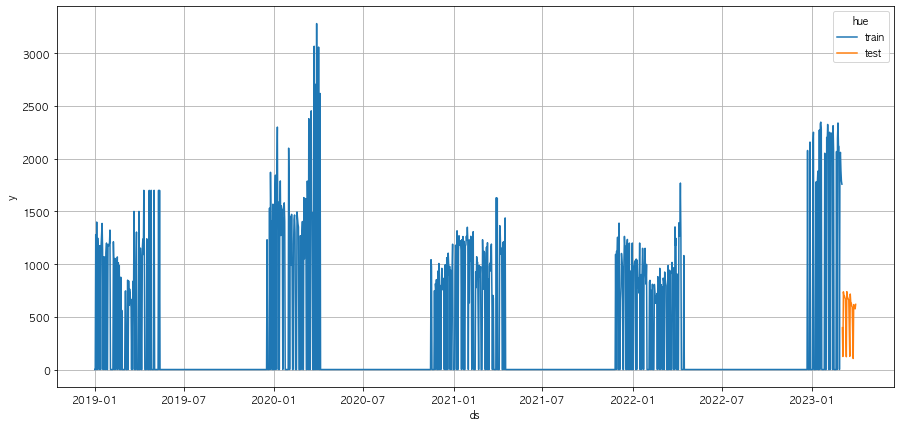

[18/39] item:CR, corporation:D, location:J:  44%|████▎     | 17/39 [24:18<22:55, 62.51s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=141.411, val_loss=240.334, elasped=4.5s
[2/4] CatBoostRegressor: loss=161.215, val_loss=243.037, elasped=3.7s
[3/4] CatBoostRegressor: loss=179.157, val_loss=238.764, elasped=1.2s
[4/4] CatBoostRegressor: loss=93.746, val_loss=247.474, elasped=10.3s
<Weighted Ensemble(weight='balanced')> loss=142.874, val_loss=240.163, elasped=19.8s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=57.967, val_loss=232.886, elasped=11.1s
[2/4] CatBoostRegressor: loss=90.226, val_loss=232.920, elasped=8.0s
[3/4] CatBoostRegressor: loss=128.412, val_loss=240.501, elasped=1.7s
[4/4] CatBoostRegressor: loss=49.771, val_loss=227.257, elasped=13.2s
<Wei

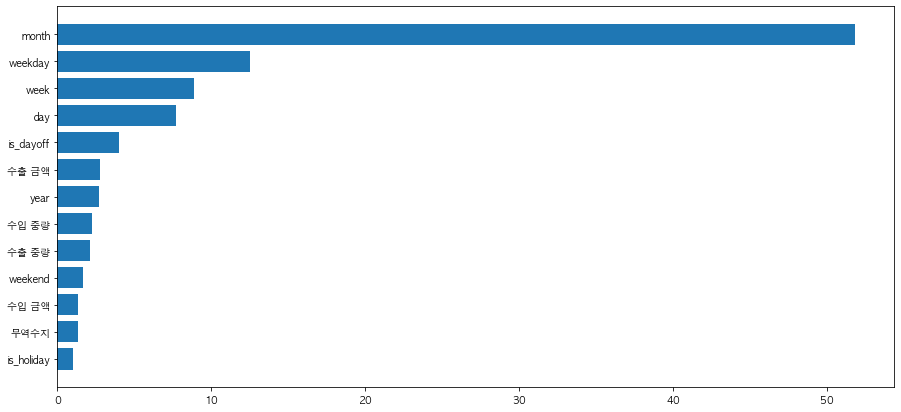

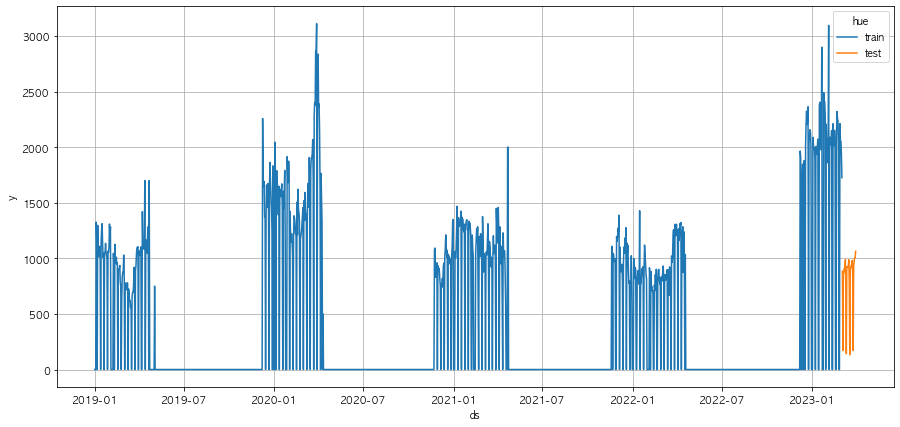

[19/39] item:CR, corporation:D, location:S:  46%|████▌     | 18/39 [26:21<28:14, 80.69s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=100.238, val_loss=7.178, elasped=1.4s
[2/4] CatBoostRegressor: loss=101.823, val_loss=7.256, elasped=0.8s
[3/4] CatBoostRegressor: loss=102.157, val_loss=7.371, elasped=0.3s
[4/4] CatBoostRegressor: loss=102.023, val_loss=7.369, elasped=2.5s
<Weighted Ensemble(weight='balanced')> loss=101.552, val_loss=7.270, elasped=5.0s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=73.730, val_loss=102.218, elasped=1.2s
[2/4] CatBoostRegressor: loss=64.202, val_loss=101.350, elasped=1.2s
[3/4] CatBoostRegressor: loss=66.955, val_loss=99.661, elasped=0.4s
[4/4] CatBoostRegressor: loss=69.650, val_loss=101.014, elasped=2.9s
<Weighted Ensemble(

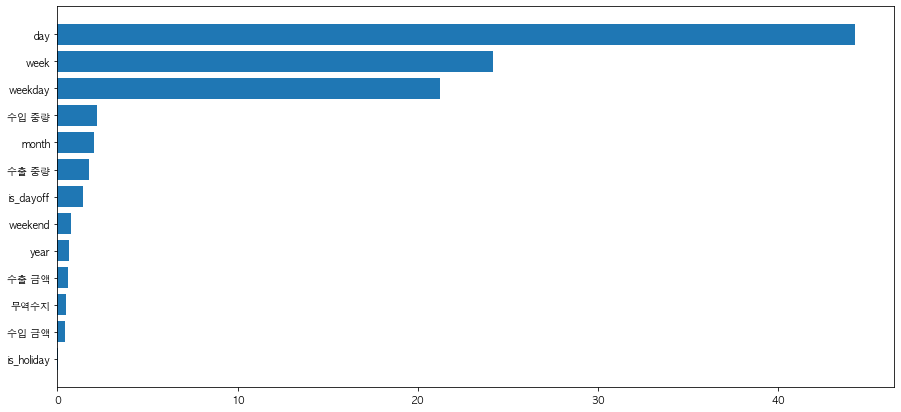

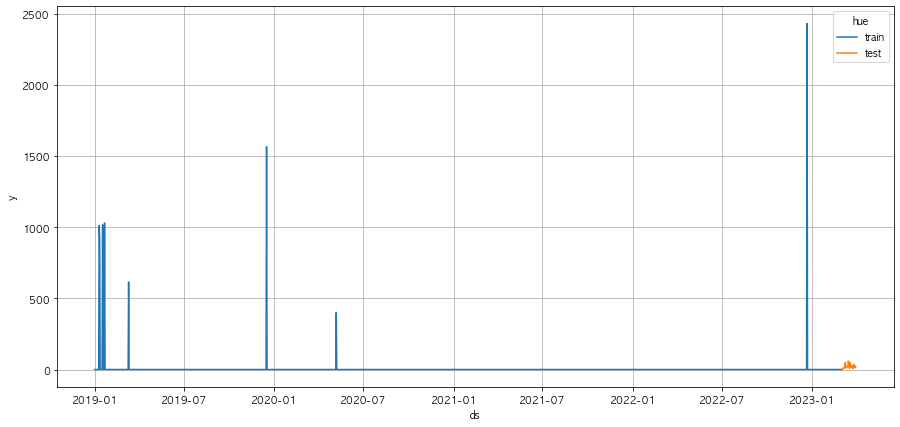

[20/39] item:CR, corporation:E, location:J:  49%|████▊     | 19/39 [26:49<21:36, 64.83s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=89.767, val_loss=219.509, elasped=6.5s
[2/4] CatBoostRegressor: loss=48.905, val_loss=208.318, elasped=13.1s
[3/4] CatBoostRegressor: loss=64.515, val_loss=213.212, elasped=3.7s
[4/4] CatBoostRegressor: loss=40.766, val_loss=216.540, elasped=14.2s
<Weighted Ensemble(weight='balanced')> loss=59.071, val_loss=211.354, elasped=37.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=111.653, val_loss=197.706, elasped=5.4s
[2/4] CatBoostRegressor: loss=129.369, val_loss=203.351, elasped=4.4s
[3/4] CatBoostRegressor: loss=81.888, val_loss=193.648, elasped=3.2s
[4/4] CatBoostRegressor: loss=49.535, val_loss=192.709, elasped=11.8s
<Weight

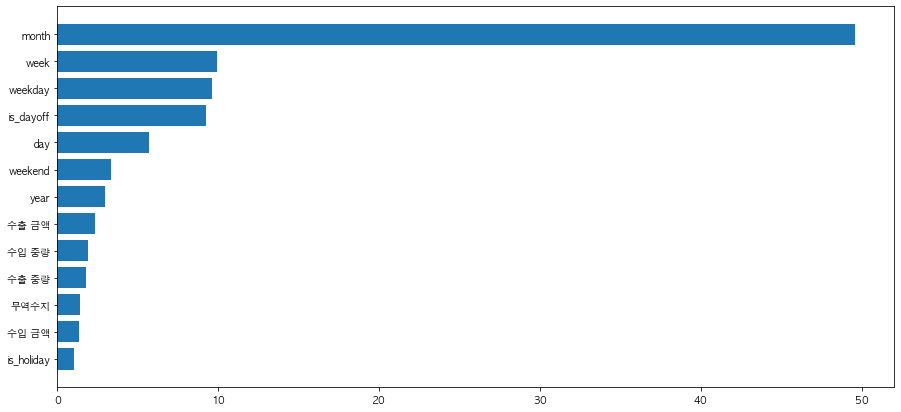

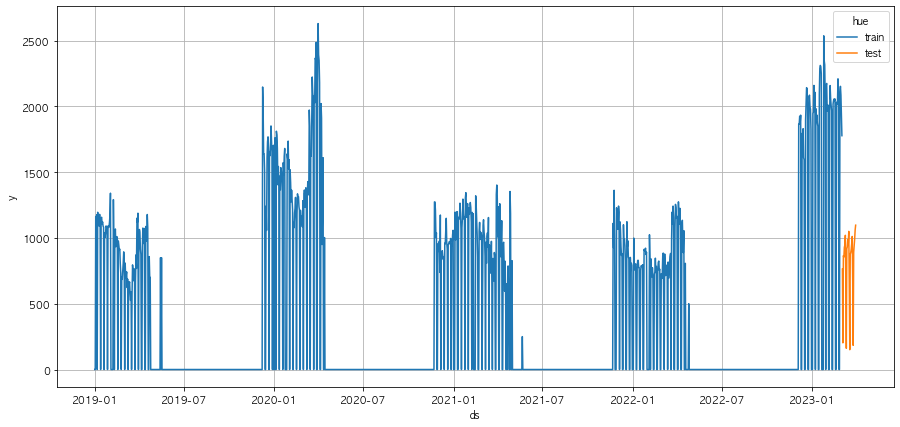

[21/39] item:CR, corporation:E, location:S:  51%|█████▏    | 20/39 [29:35<30:06, 95.10s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=102.393, val_loss=199.583, elasped=1.0s
[2/4] CatBoostRegressor: loss=100.565, val_loss=199.231, elasped=1.0s
[3/4] CatBoostRegressor: loss=99.428, val_loss=197.740, elasped=0.4s
[4/4] CatBoostRegressor: loss=103.110, val_loss=200.550, elasped=3.5s
<Weighted Ensemble(weight='balanced')> loss=101.174, val_loss=199.086, elasped=6.0s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=104.925, val_loss=103.176, elasped=1.4s
[2/4] CatBoostRegressor: loss=109.557, val_loss=102.139, elasped=1.4s
[3/4] CatBoostRegressor: loss=114.195, val_loss=102.753, elasped=0.4s
[4/4] CatBoostRegressor: loss=89.732, val_loss=104.335, elasped=4.8s
<Weigh

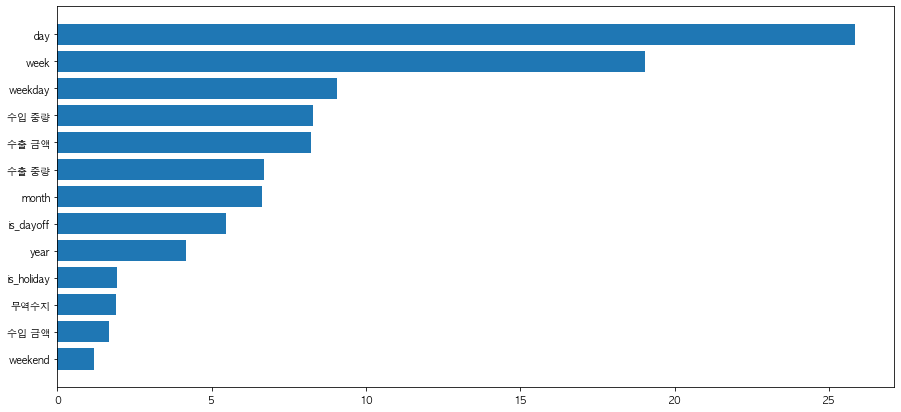

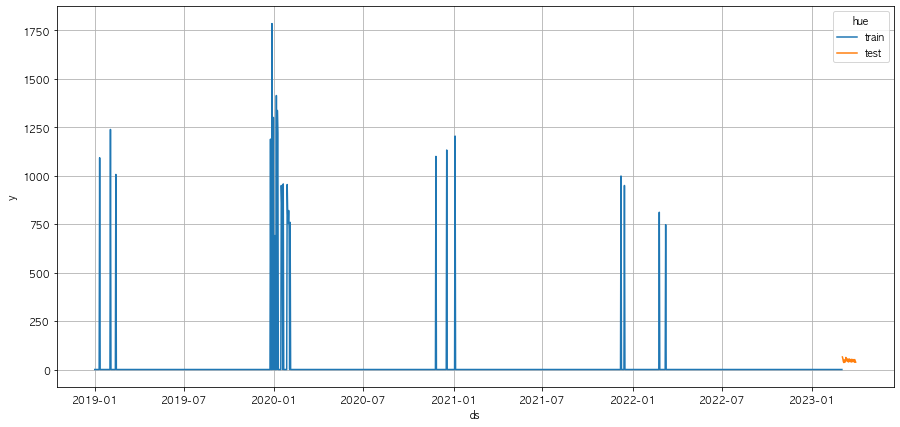

[22/39] item:RD, corporation:A, location:J:  54%|█████▍    | 21/39 [30:12<23:20, 77.82s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=219.649, val_loss=347.001, elasped=1.8s
[2/4] CatBoostRegressor: loss=280.743, val_loss=340.574, elasped=1.0s
[3/4] CatBoostRegressor: loss=257.016, val_loss=347.047, elasped=0.5s
[4/4] CatBoostRegressor: loss=239.124, val_loss=342.519, elasped=2.5s
<Weighted Ensemble(weight='balanced')> loss=247.539, val_loss=342.844, elasped=5.8s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=111.545, val_loss=287.478, elasped=4.1s
[2/4] CatBoostRegressor: loss=180.238, val_loss=299.082, elasped=2.6s
[3/4] CatBoostRegressor: loss=148.889, val_loss=289.105, elasped=1.2s
[4/4] CatBoostRegressor: loss=82.967, val_loss=299.640, elasped=7.3s
<Weig

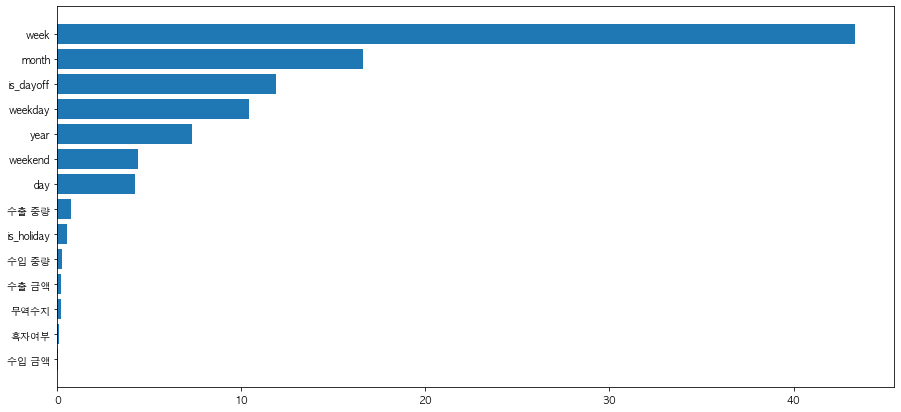

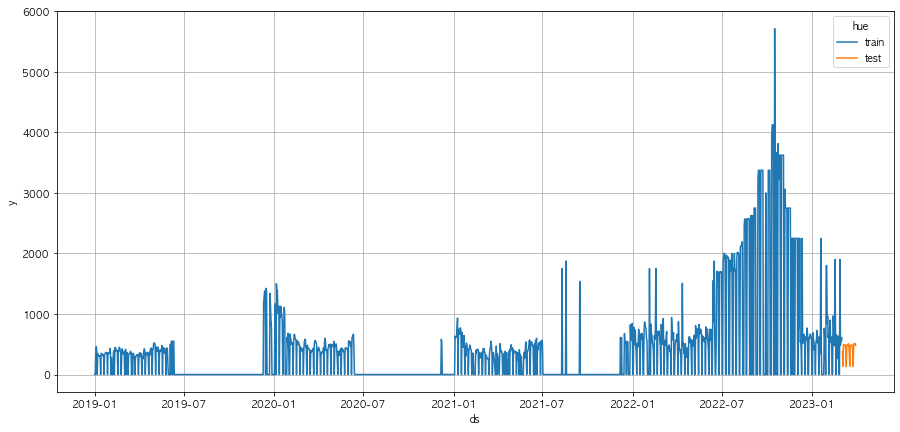

[23/39] item:RD, corporation:A, location:S:  56%|█████▋    | 22/39 [31:01<19:34, 69.11s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=73.436, val_loss=130.603, elasped=2.1s
[2/4] CatBoostRegressor: loss=75.184, val_loss=129.564, elasped=2.0s
[3/4] CatBoostRegressor: loss=66.793, val_loss=129.205, elasped=1.1s
[4/4] CatBoostRegressor: loss=60.082, val_loss=130.827, elasped=4.0s
<Weighted Ensemble(weight='balanced')> loss=68.246, val_loss=129.389, elasped=9.2s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=71.879, val_loss=114.520, elasped=2.4s
[2/4] CatBoostRegressor: loss=76.393, val_loss=113.413, elasped=2.1s
[3/4] CatBoostRegressor: loss=90.703, val_loss=119.307, elasped=0.6s
[4/4] CatBoostRegressor: loss=34.733, val_loss=115.967, elasped=6.7s
<Weighted Ens

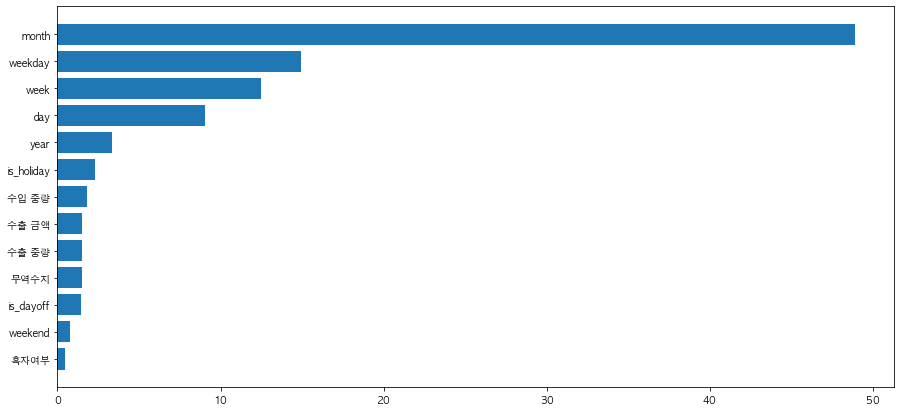

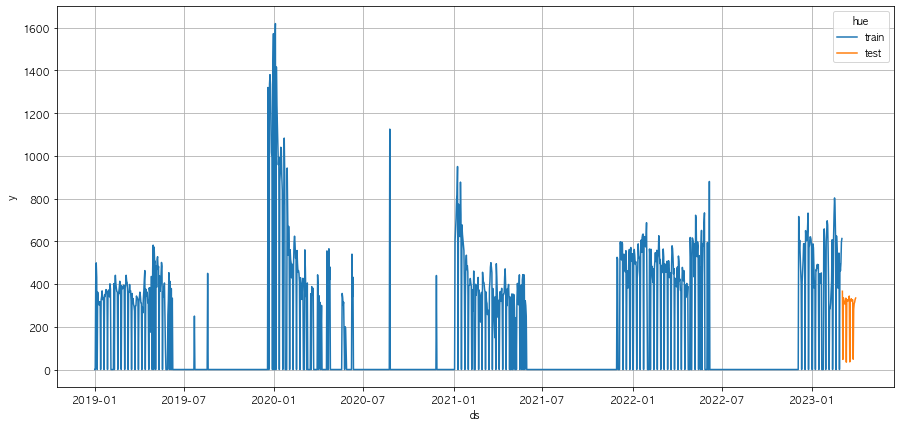

[24/39] item:RD, corporation:C, location:S:  59%|█████▉    | 23/39 [32:13<18:37, 69.83s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=51.156, val_loss=18.800, elasped=0.5s
[2/4] CatBoostRegressor: loss=51.492, val_loss=18.877, elasped=0.4s
[3/4] CatBoostRegressor: loss=51.917, val_loss=18.918, elasped=0.1s
[4/4] CatBoostRegressor: loss=50.707, val_loss=18.800, elasped=1.3s
<Weighted Ensemble(weight='balanced')> loss=51.315, val_loss=18.835, elasped=2.3s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=26.946, val_loss=50.689, elasped=1.5s
[2/4] CatBoostRegressor: loss=31.344, val_loss=49.435, elasped=1.2s
[3/4] CatBoostRegressor: loss=31.953, val_loss=49.591, elasped=0.4s
[4/4] CatBoostRegressor: loss=20.884, val_loss=51.404, elasped=2.6s
<Weighted Ensemble(wei

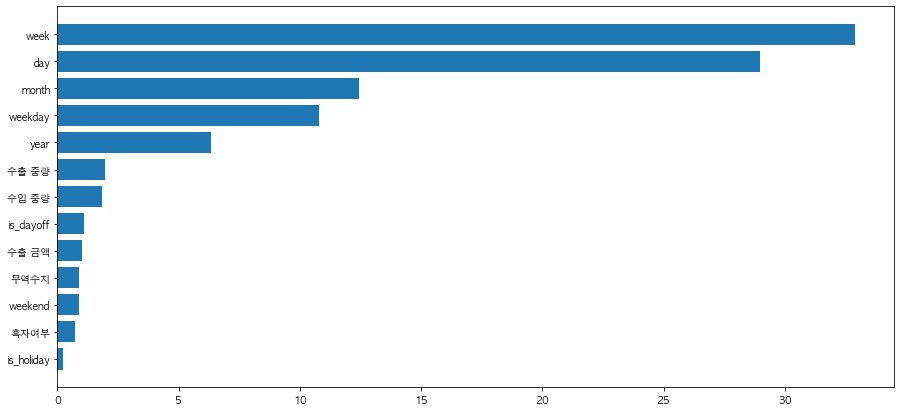

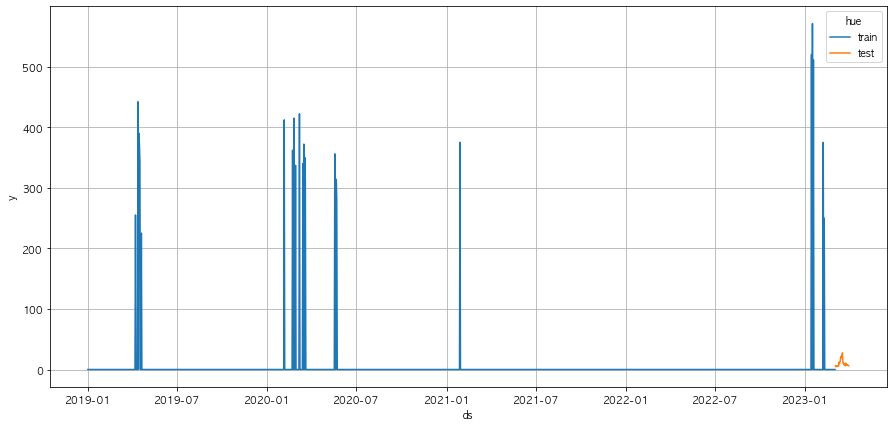

[25/39] item:RD, corporation:D, location:J:  62%|██████▏   | 24/39 [32:29<13:26, 53.77s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=83.508, val_loss=150.650, elasped=2.2s
[2/4] CatBoostRegressor: loss=79.394, val_loss=147.692, elasped=2.8s
[3/4] CatBoostRegressor: loss=75.560, val_loss=144.094, elasped=1.2s
[4/4] CatBoostRegressor: loss=71.966, val_loss=155.197, elasped=4.0s
<Weighted Ensemble(weight='balanced')> loss=76.848, val_loss=148.482, elasped=10.3s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=85.875, val_loss=141.195, elasped=2.3s
[2/4] CatBoostRegressor: loss=98.165, val_loss=142.910, elasped=1.8s
[3/4] CatBoostRegressor: loss=91.282, val_loss=142.485, elasped=0.9s
[4/4] CatBoostRegressor: loss=70.843, val_loss=145.938, elasped=4.0s
<Weighted En

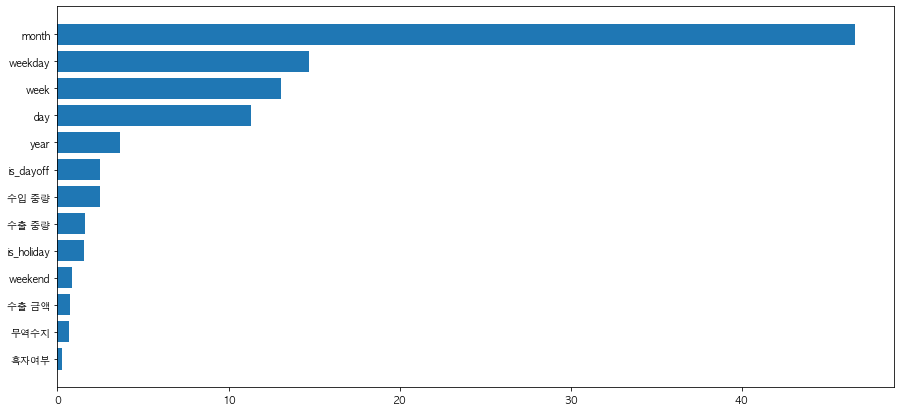

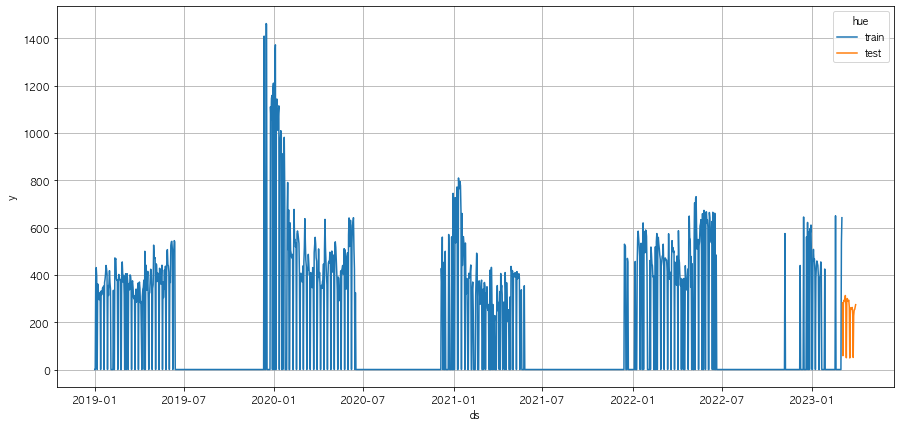

[26/39] item:RD, corporation:D, location:S:  64%|██████▍   | 25/39 [33:22<12:28, 53.48s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=60.686, val_loss=117.536, elasped=5.3s
[2/4] CatBoostRegressor: loss=67.053, val_loss=121.207, elasped=4.8s
[3/4] CatBoostRegressor: loss=58.271, val_loss=114.642, elasped=3.3s
[4/4] CatBoostRegressor: loss=55.451, val_loss=118.146, elasped=9.3s
<Weighted Ensemble(weight='balanced')> loss=59.561, val_loss=116.816, elasped=22.7s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=86.122, val_loss=133.335, elasped=2.9s
[2/4] CatBoostRegressor: loss=91.125, val_loss=134.027, elasped=3.1s
[3/4] CatBoostRegressor: loss=89.117, val_loss=132.573, elasped=1.4s
[4/4] CatBoostRegressor: loss=61.383, val_loss=136.116, elasped=7.8s
<Weighted En

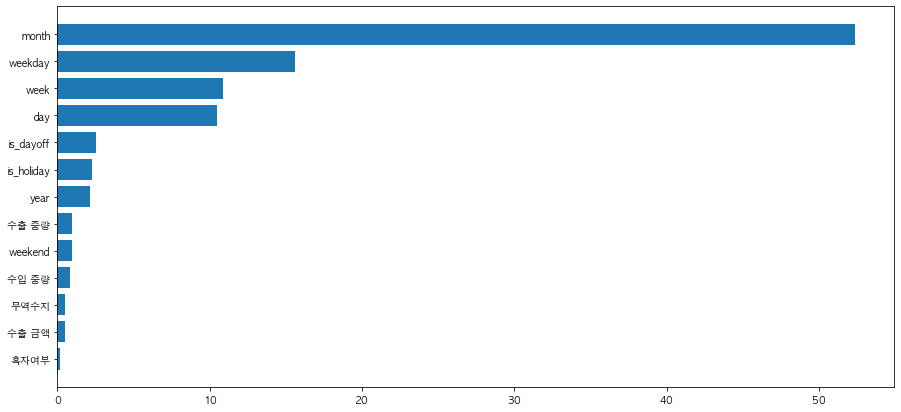

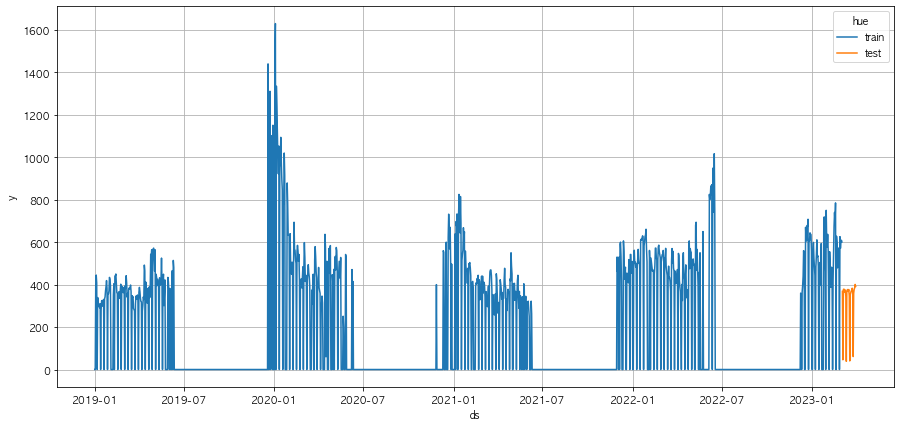

[27/39] item:RD, corporation:E, location:J:  67%|██████▋   | 26/39 [35:15<15:26, 71.30s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=69.563, val_loss=130.450, elasped=5.9s
[2/4] CatBoostRegressor: loss=88.809, val_loss=133.287, elasped=3.4s
[3/4] CatBoostRegressor: loss=73.069, val_loss=128.430, elasped=3.0s
[4/4] CatBoostRegressor: loss=57.652, val_loss=131.281, elasped=10.2s
<Weighted Ensemble(weight='balanced')> loss=71.188, val_loss=129.168, elasped=22.5s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=84.635, val_loss=140.564, elasped=5.5s
[2/4] CatBoostRegressor: loss=91.047, val_loss=139.660, elasped=3.8s
[3/4] CatBoostRegressor: loss=111.014, val_loss=141.589, elasped=1.2s
[4/4] CatBoostRegressor: loss=89.956, val_loss=147.512, elasped=6.3s
<Weighted 

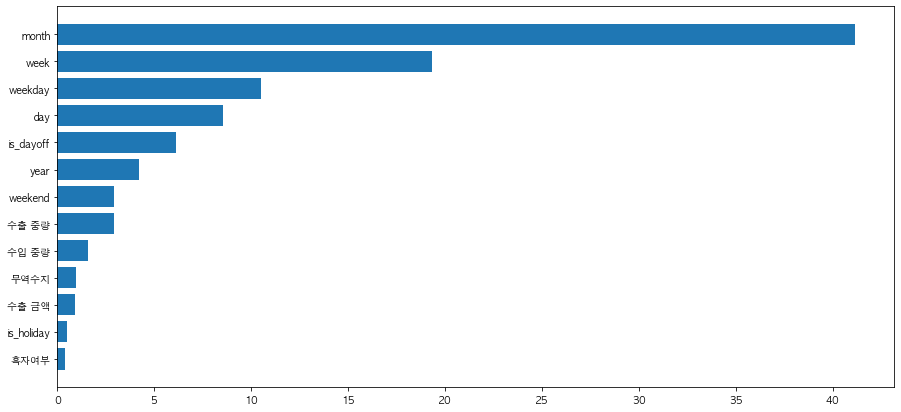

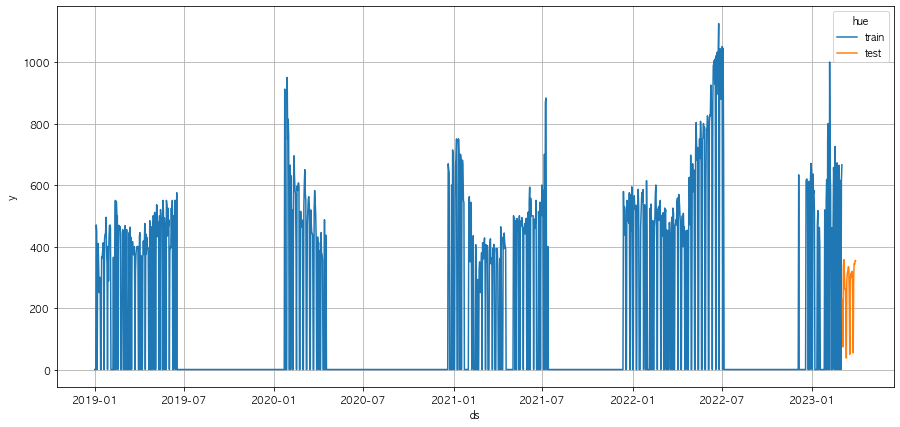

[28/39] item:RD, corporation:E, location:S:  69%|██████▉   | 27/39 [36:42<15:12, 76.01s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=97.423, val_loss=172.318, elasped=2.9s
[2/4] CatBoostRegressor: loss=103.131, val_loss=169.004, elasped=2.8s
[3/4] CatBoostRegressor: loss=97.938, val_loss=172.037, elasped=1.2s
[4/4] CatBoostRegressor: loss=79.849, val_loss=172.799, elasped=6.0s
<Weighted Ensemble(weight='balanced')> loss=93.909, val_loss=170.829, elasped=12.9s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=109.441, val_loss=155.068, elasped=2.7s
[2/4] CatBoostRegressor: loss=115.903, val_loss=153.408, elasped=2.2s
[3/4] CatBoostRegressor: loss=121.282, val_loss=155.230, elasped=0.9s
[4/4] CatBoostRegressor: loss=88.632, val_loss=158.590, elasped=5.0s
<Weighte

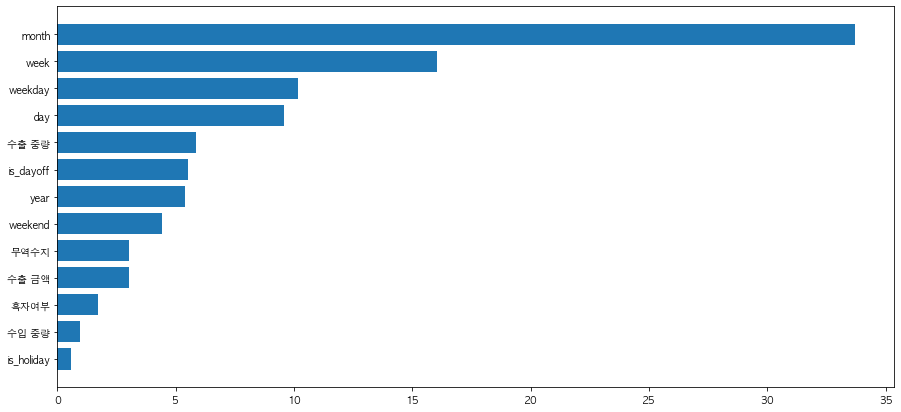

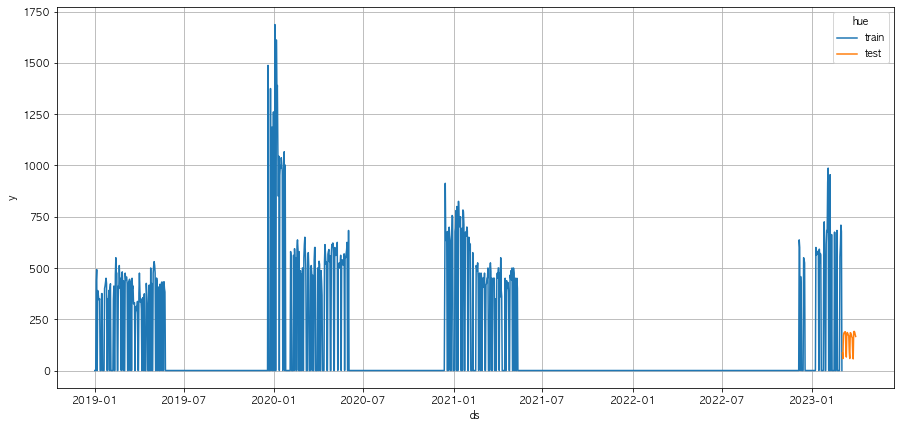

[29/39] item:RD, corporation:F, location:J:  72%|███████▏  | 28/39 [37:25<12:08, 66.24s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=30.231, val_loss=90.231, elasped=6.4s
[2/4] CatBoostRegressor: loss=39.246, val_loss=91.613, elasped=4.9s
[3/4] CatBoostRegressor: loss=40.935, val_loss=82.927, elasped=1.9s
[4/4] CatBoostRegressor: loss=19.534, val_loss=91.977, elasped=9.3s
<Weighted Ensemble(weight='balanced')> loss=32.203, val_loss=88.066, elasped=22.4s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=24.959, val_loss=82.525, elasped=6.6s
[2/4] CatBoostRegressor: loss=36.975, val_loss=85.116, elasped=4.7s
[3/4] CatBoostRegressor: loss=36.434, val_loss=81.227, elasped=2.2s
[4/4] CatBoostRegressor: loss=16.085, val_loss=84.310, elasped=11.2s
<Weighted Ensemble(w

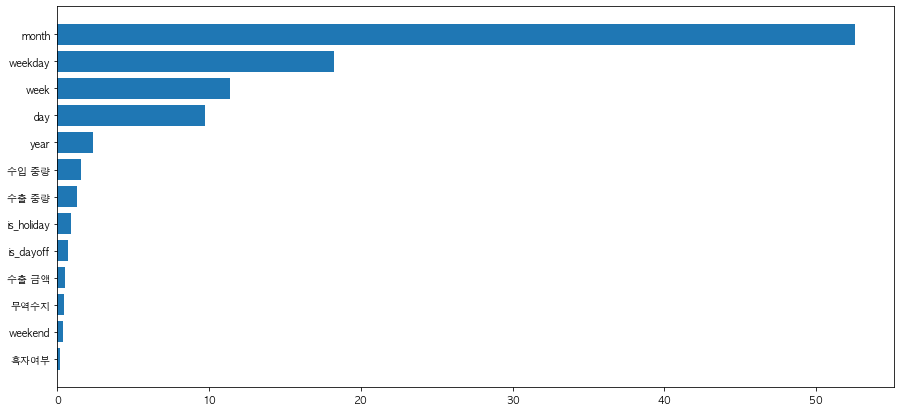

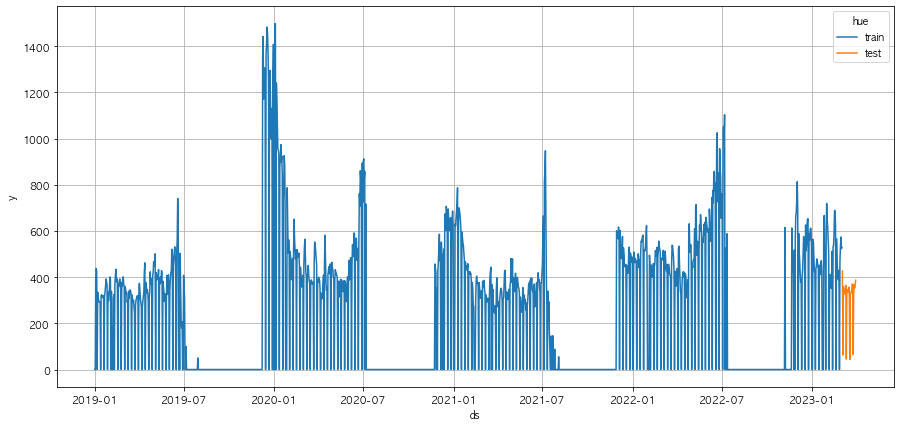

[30/39] item:TG, corporation:A, location:J:  74%|███████▍  | 29/39 [42:27<22:50, 137.02s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1804.884, val_loss=2091.612, elasped=1.1s
[2/4] CatBoostRegressor: loss=1866.907, val_loss=2091.277, elasped=0.8s
[3/4] CatBoostRegressor: loss=1869.057, val_loss=2089.227, elasped=0.3s
[4/4] CatBoostRegressor: loss=1684.283, val_loss=2106.688, elasped=2.9s
<Weighted Ensemble(weight='balanced')> loss=1800.811, val_loss=2088.817, elasped=5.2s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1689.269, val_loss=1829.452, elasped=1.7s
[2/4] CatBoostRegressor: loss=1760.491, val_loss=1828.478, elasped=1.4s
[3/4] CatBoostRegressor: loss=1769.582, val_loss=1834.318, elasped=0.5s
[4/4] CatBoostRegressor: loss=1529.321, val_loss=1876.499,

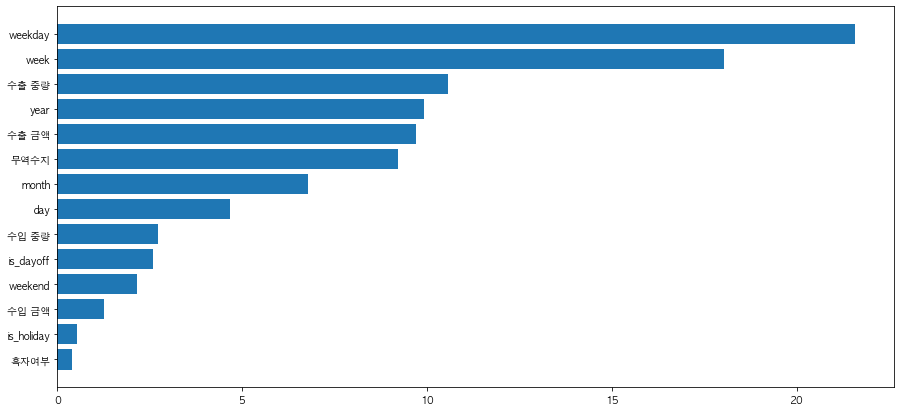

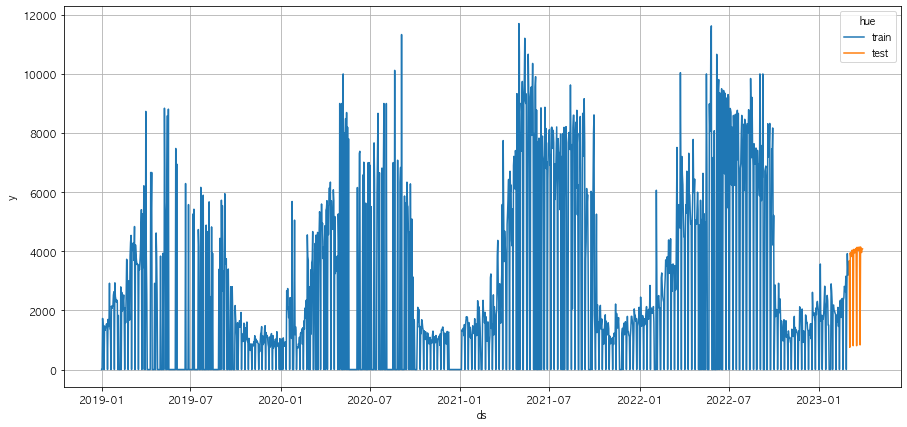

[31/39] item:TG, corporation:A, location:S:  77%|███████▋  | 30/39 [42:59<15:49, 105.54s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=527.350, val_loss=899.924, elasped=2.6s
[2/4] CatBoostRegressor: loss=537.164, val_loss=907.229, elasped=2.4s
[3/4] CatBoostRegressor: loss=446.897, val_loss=904.920, elasped=1.4s
[4/4] CatBoostRegressor: loss=449.771, val_loss=909.984, elasped=5.7s
<Weighted Ensemble(weight='balanced')> loss=485.862, val_loss=901.422, elasped=12.1s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=562.468, val_loss=694.722, elasped=2.6s
[2/4] CatBoostRegressor: loss=608.004, val_loss=695.182, elasped=1.9s
[3/4] CatBoostRegressor: loss=529.397, val_loss=698.326, elasped=1.0s
[4/4] CatBoostRegressor: loss=487.712, val_loss=709.014, elasped=5.2s
<We

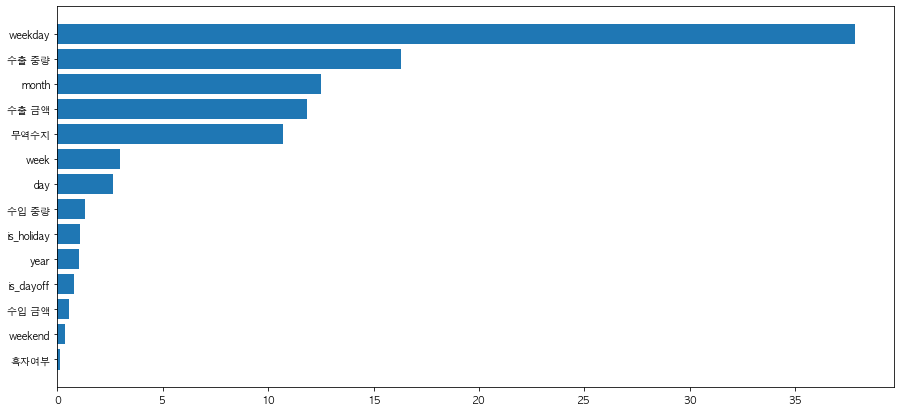

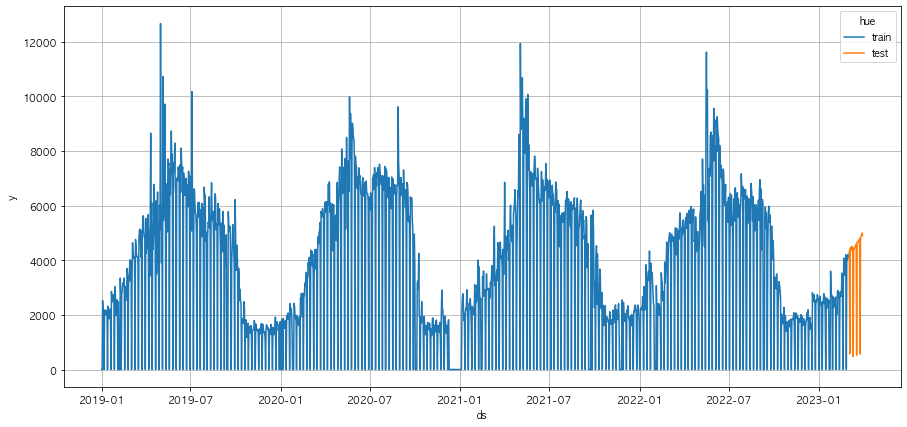

[32/39] item:TG, corporation:B, location:J:  79%|███████▉  | 31/39 [44:18<12:59, 97.45s/it] 


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1166.298, val_loss=1745.950, elasped=4.5s
[2/4] CatBoostRegressor: loss=1193.417, val_loss=1740.509, elasped=4.2s
[3/4] CatBoostRegressor: loss=1170.090, val_loss=1744.027, elasped=2.1s
[4/4] CatBoostRegressor: loss=1203.388, val_loss=1760.483, elasped=7.2s
<Weighted Ensemble(weight='balanced')> loss=1177.526, val_loss=1742.872, elasped=18.0s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1377.775, val_loss=1751.709, elasped=2.9s
[2/4] CatBoostRegressor: loss=1434.621, val_loss=1736.048, elasped=2.5s
[3/4] CatBoostRegressor: loss=1470.659, val_loss=1745.871, elasped=1.1s
[4/4] CatBoostRegressor: loss=1210.518, val_loss=1750.126

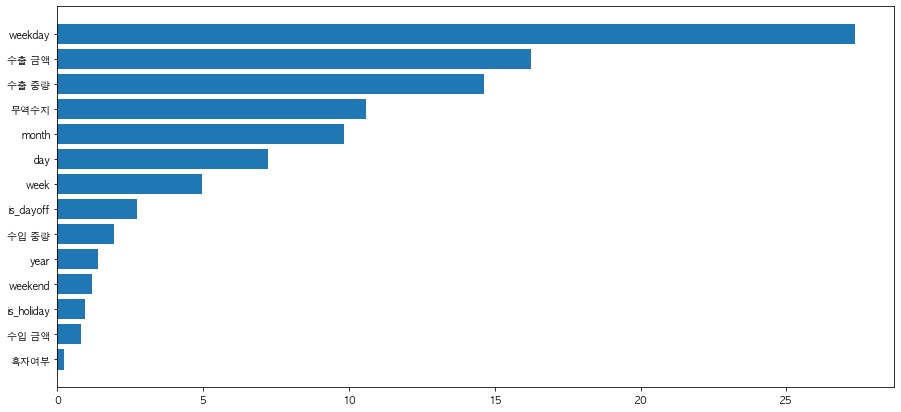

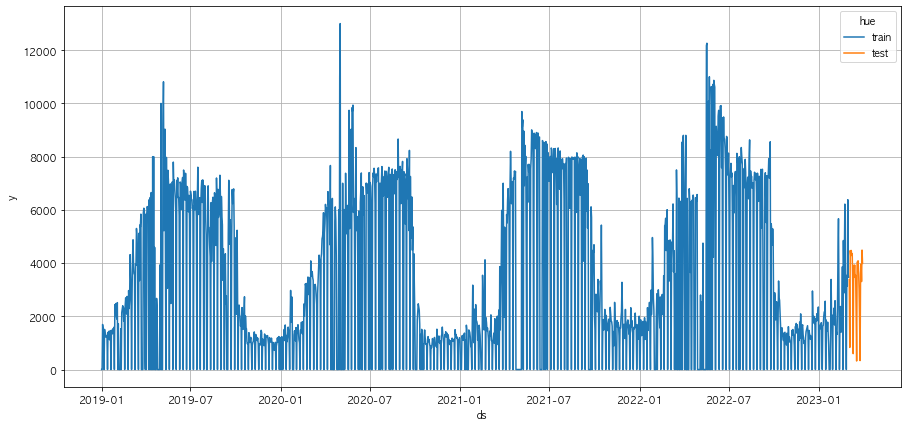

[33/39] item:TG, corporation:B, location:S:  82%|████████▏ | 32/39 [45:48<11:07, 95.31s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=739.460, val_loss=1075.601, elasped=4.5s
[2/4] CatBoostRegressor: loss=816.933, val_loss=1088.211, elasped=3.7s
[3/4] CatBoostRegressor: loss=748.250, val_loss=1071.993, elasped=1.6s
[4/4] CatBoostRegressor: loss=655.138, val_loss=1092.624, elasped=9.6s
<Weighted Ensemble(weight='balanced')> loss=736.798, val_loss=1078.636, elasped=19.4s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=899.876, val_loss=1039.926, elasped=3.3s
[2/4] CatBoostRegressor: loss=914.909, val_loss=1034.886, elasped=2.8s
[3/4] CatBoostRegressor: loss=870.461, val_loss=1045.520, elasped=1.3s
[4/4] CatBoostRegressor: loss=789.903, val_loss=1056.283, elasped

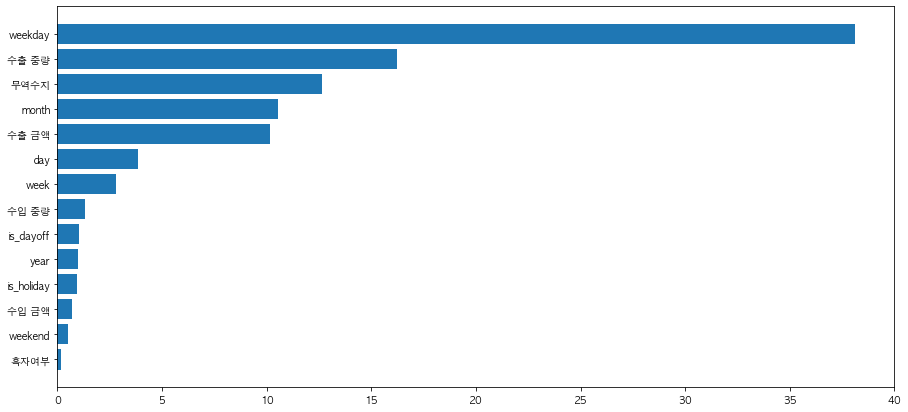

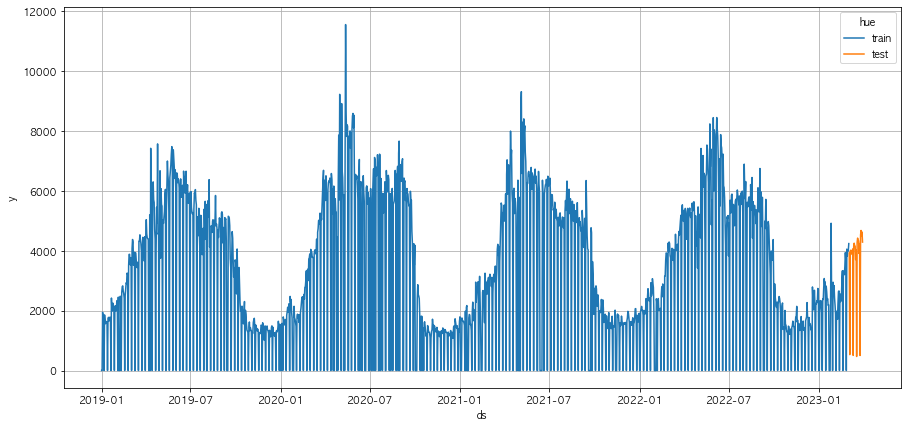

[34/39] item:TG, corporation:C, location:J:  85%|████████▍ | 33/39 [46:58<08:46, 87.75s/it]


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1365.601, val_loss=1899.741, elasped=2.6s
[2/4] CatBoostRegressor: loss=1367.290, val_loss=1901.091, elasped=2.6s
[3/4] CatBoostRegressor: loss=1210.675, val_loss=1927.236, elasped=1.4s
[4/4] CatBoostRegressor: loss=1314.328, val_loss=1876.213, elasped=4.7s
<Weighted Ensemble(weight='balanced')> loss=1306.153, val_loss=1892.348, elasped=11.3s

--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=1629.807, val_loss=2056.444, elasped=2.0s
[2/4] CatBoostRegressor: loss=1736.083, val_loss=2027.936, elasped=1.6s
[3/4] CatBoostRegressor: loss=1779.633, val_loss=2060.404, elasped=0.5s
[4/4] CatBoostRegressor: loss=1361.854, val_loss=2082.834

[34/39] item:TG, corporation:C, location:J:  85%|████████▍ | 33/39 [47:39<08:39, 86.64s/it]

KeyboardInterrupt



In [34]:
models = []
i=0

grps = train_df[CFG.KEY_FEATURES].drop_duplicates().values
pbar = tqdm(grps)
for item,corp,loc in pbar:
    i+=1
    str_i = str(i).zfill(len(str(len(grps))))
    progress = '[{}/{}] item:{}, corporation:{}, location:{}'.format(str_i,len(grps),item,corp,loc)
    pbar.set_description(progress)
    
    tr_data = get_seg_data(train_df,item,corp,loc)
    te_data = get_seg_data(test_df ,item,corp,loc)
    
    y = tr_data[CFG.TARGET]

    X      = tr_data.drop([CFG.TARGET,'timestamp'],axis=1)
    X_test = te_data.drop('timestamp',axis=1)

    model = KfoldWeightedEnsembleRegressor(
        hyperparameters,
        method='ensemble',
        weight='balanced',
        inverse_transform=target_transform.inverse_transform,
        eval_metric=None,
        use_ensemble=True,
        n_splits=CFG.N_SPLITS,
        random_state=CFG.SEED,
    )
    model.fit(
        X,y,
        cat_features=cat_features,
        sample_weight=None,
        verbose=True,
    )
    save_model_path = './mc/weiens_item:{}_corporation:{}_location:{}.pickle'.format(item,corp,loc)
    model.save_model(save_model_path)
    models.append(model)
    
    plot_df = pd.DataFrame({
        'ds' : tr_data['timestamp'].tolist() + te_data['timestamp'].tolist(),
        'y' : target_transform.inverse_transform(tr_data[CFG.TARGET]).flatten().tolist() + model.predict(X_test).tolist(),
        'hue' : ['train']*len(tr_data) + ['test']*len(te_data),
    })

    plt.figure(figsize=(15,7))
    sns.lineplot(x=plot_df.ds,y=plot_df.y,hue=plot_df.hue)
    plt.grid()
    plt.show()

In [ ]:
grps = train_df[CFG.KEY_FEATURES].drop_duplicates().values

tr_preds = []
te_preds = []
for model,(item,corp,loc) in tqdm(zip(models,grps),total=len(grps)):
    i+=1
    str_i = str(i).zfill(len(str(len(grps))))
    progress = '[{}/{}] item:{}, corporation:{}, location:{}'.format(str_i,len(grps),item,corp,loc)
    pbar.set_description(progress)
    
    tr_data = get_seg_data(train_df,item,corp,loc)
    te_data = get_seg_data(test_df ,item,corp,loc)
    
    tr_pred = pd.DataFrame({'pred' : model.predict(tr_data),'true' : tr_data[CFG.TARGET]},index=tr_data.index)
    te_pred = pd.DataFrame({'pred' : model.predict(te_data)},index=te_data.index)
    tr_pred['true'] = target_transform.inverse_transform(tr_pred['true'])
    
    tr_preds.append(tr_pred)
    te_preds.append(te_pred)

In [ ]:
tr_pred_df = pd.concat(tr_preds,axis=0).sort_index()
te_pred_df = pd.concat(te_preds,axis=0).sort_index()

mean_squared_error(tr_pred_df.true,tr_pred_df.pred)**0.5

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = te_pred_df.pred
submit.to_csv('./out/submit_seg_log.csv',index=False)
submit.head()